# The Value of Existential Risk Mitigation: Companion Notebook

Author: [Arvo Muñoz Morán](https://www.arvomm.com/)

This is the companion notebook to the "Technical Report: The Value of Existential Risk Mitigation", which is a project of The Worldview Investigations Team at [Rethink Priorities](https://rethinkpriorities.org/research)

In [1]:
from datetime import date

today = date.today()
formatted_date = today.strftime('%d %B %Y')

print(f"Last Updated: ",formatted_date)

Last Updated:  13 September 2023


All the imports needed for the notebook (which need installing if the haven't been already) are in the cell below. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Image, display

In [3]:
# skip_execution = True # skip execution of certain cells
skip_execution = True

# The value of the world given existential risk

Let us start by directly translating Equation (1) of the generalised model into Python.

In [4]:
def calculate_Ew(T, v, r):
    Ew = 0
    
    for i in range(T): # i=0,1,2, ... T-1
        prod_term = 1
        
        for j in range(i+1):  # j=0,1,2, ... i
            prod_term *= (1 - r[j])
            
        Ew += prod_term * v[i]
        
    return Ew

# Quick Example

# Set the parameters
T = 1000

# For the purpose of this example, I'll use uniform values for `v` and `r`
# v = [1, 1, ... 1] and r = [0.01, 0.01, ... 0.01]
# The reader can change these values as per their requirements

v = [1 for _ in range(T)]
r = [0.01 for _ in range(T)]

# Calculate E(w)
Ew = calculate_Ew(T, v, r)

# Printing the results along with the parameters
print("Quick example:")
print("--------------")
print("T =", T)
print("v (first 5 elements for brevity) =", v[:5])
print("r (first 5 elements for brevity) =", r[:5])
print("E(w) =", Ew)
# True value at infty for v = [1 for _ in range(T)] , r = [0.01 for _ in range(T)] should be 
# S = a1/(1-R)=99 since a1=1-r and R=1-r=1-0.01=0.99
# And it is.


Quick example:
--------------
T = 1000
v (first 5 elements for brevity) = [1, 1, 1, 1, 1]
r (first 5 elements for brevity) = [0.01, 0.01, 0.01, 0.01, 0.01]
E(w) = 98.99572604650623


# Different Value Paths

Let us now put into code the main value paths we are interested in:
- constant value
- linear value
- quadratic value
- cubic value
- logit value
- and others (custom)

From this point onwards we normalise the value of the world next year $v_c$ to 1.

First, we define a time adjustment function to adjust the time scale of the value vector from centuries to years, or to any other scale captured by the alpha parameter. Second, we define a function that returns the sequence of values of the world, given a path and a time adjustment function.

In [5]:
# Time adjustment function
def time_adjustment(input, alpha):
    return alpha * input + (1 - alpha)
#alpha is simply 1/units_in_century

# Value sequence generator given the path type
def generate_value_vector(T, v_type="constant", custom_v=None, alpha=0.01, forplot=False):
    # Initialize the value vector based on the preset option
    if v_type == "constant":
        v = [1 for _ in range(T)]
    elif v_type == "linear":
        v = [time_adjustment(i+1,alpha) for i in range(T)]
    elif v_type == "quadratic":
        v = [(time_adjustment(i+1,alpha))**2 for i in range(T)]
    elif v_type == "cubic":
        v = [(time_adjustment(i+1,alpha))**3 for i in range(T)]
    elif v_type == "logistic":
        # Key parameters
        c = (100)**3 # The value cap. Here, what obtains after 100,00 of cubic growth
        exp_rate = 0.03 # 3% annually i.e. when alpha=0.01
        mod_rate = exp_rate*(alpha/0.01 + 10*np.exp(1)*alpha-np.exp(1)*0.1) # modifications for other alphas
        v_0 = c / ((c - 1) * np.exp(mod_rate) + 1) # The value at zero, chosen so that value at i=1 is 1.
    
        # Function for the ith term
        v = [c / (1 + ((c - v_0) / v_0 )* np.exp(-mod_rate * (i+1))) for i in range(T)] # if in doubt, see graph below 
    elif v_type == "custom":
        if custom_v is None:
            custom_v = list(map(int, input("Enter your custom v vector separated by spaces: ").split()))
        v = custom_v
    
    return v

# Examples of first ten years with each of the types

types = ["constant", "linear", "quadratic", "cubic", "logistic"]
T = 10
v_type = "constant"

print("Quick example for 1 period = 1 year (alpha=0.01):")

for v_type in types:
    v = generate_value_vector(T, v_type)
    print("Quick example:")
    print(f"Generated value sequence (v) of type '{v_type}': {v}")
    print("--------------")
    
# We can print the same example again for alpha=1

print(" ")
print(" ")
print("Quick example for 1 period = 1 century (alpha=1):")

for v_type in types:
    v = generate_value_vector(T, v_type, alpha=1)
    print(f"Generated value sequence (v) of type '{v_type}': {v}")
    print("--------------")


Quick example for 1 period = 1 year (alpha=0.01):
Quick example:
Generated value sequence (v) of type 'constant': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------
Quick example:
Generated value sequence (v) of type 'linear': [1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09]
--------------
Quick example:
Generated value sequence (v) of type 'quadratic': [1.0, 1.0201, 1.0404, 1.0609, 1.0816000000000001, 1.1025, 1.1236000000000002, 1.1449, 1.1664, 1.1881000000000002]
--------------
Quick example:
Generated value sequence (v) of type 'cubic': [1.0, 1.0303010000000001, 1.0612080000000002, 1.092727, 1.124864, 1.1576250000000001, 1.191016, 1.225043, 1.2597120000000002, 1.2950290000000002]
--------------
Quick example:
Generated value sequence (v) of type 'logistic': [1.0, 1.0304545025715053, 1.0618364808850587, 1.0941741806621406, 1.1274967078270954, 1.1618340547037487, 1.197217127009805, 1.233677771673315, 1.2712488054962463, 1.3099640446909617]
--------------
 
 
Quick example for 1 

We can now plot these value paths (when periods are centuries, like in the original work by Ord).

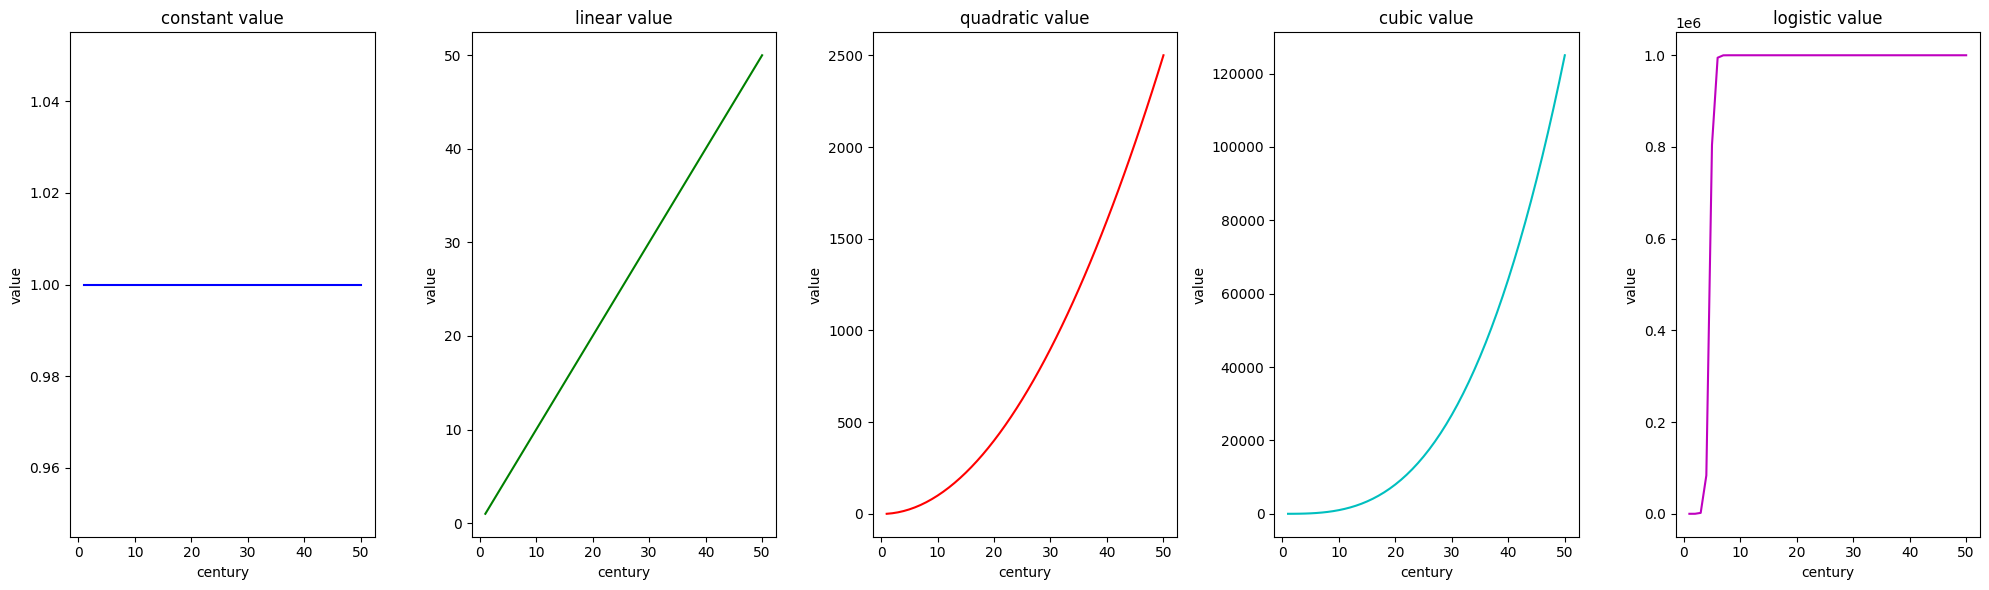

In [6]:
def plot_value_scenarios(T=50, alpha=1):
    types = ["constant", "linear", "quadratic", "cubic", "logistic"]
    colors = ["b", "g", "r", "c", "m"]

    plt.figure(figsize=(20, 6))

    for i, v_type in enumerate(types):
        plt.subplot(1, 5, i + 1)
        v = generate_value_vector(T, v_type, alpha=alpha, forplot=True)
        plt.plot(range(1, T + 1), v, color=colors[i])
        plt.title(f"{v_type} value")
        plt.xlabel("period")
        if alpha == 1:
            plt.xlabel("century")
        elif alpha == 0.01:
            plt.xlabel("year")
        else:
            plt.xlabel("period")
        plt.ylabel("value")

    plt.tight_layout()
    plt.show()
plot_value_scenarios()

And we can plot these value paths when periods are years. See how, as expected, these two match when the $T$ in years is $100$ times that of centuries.

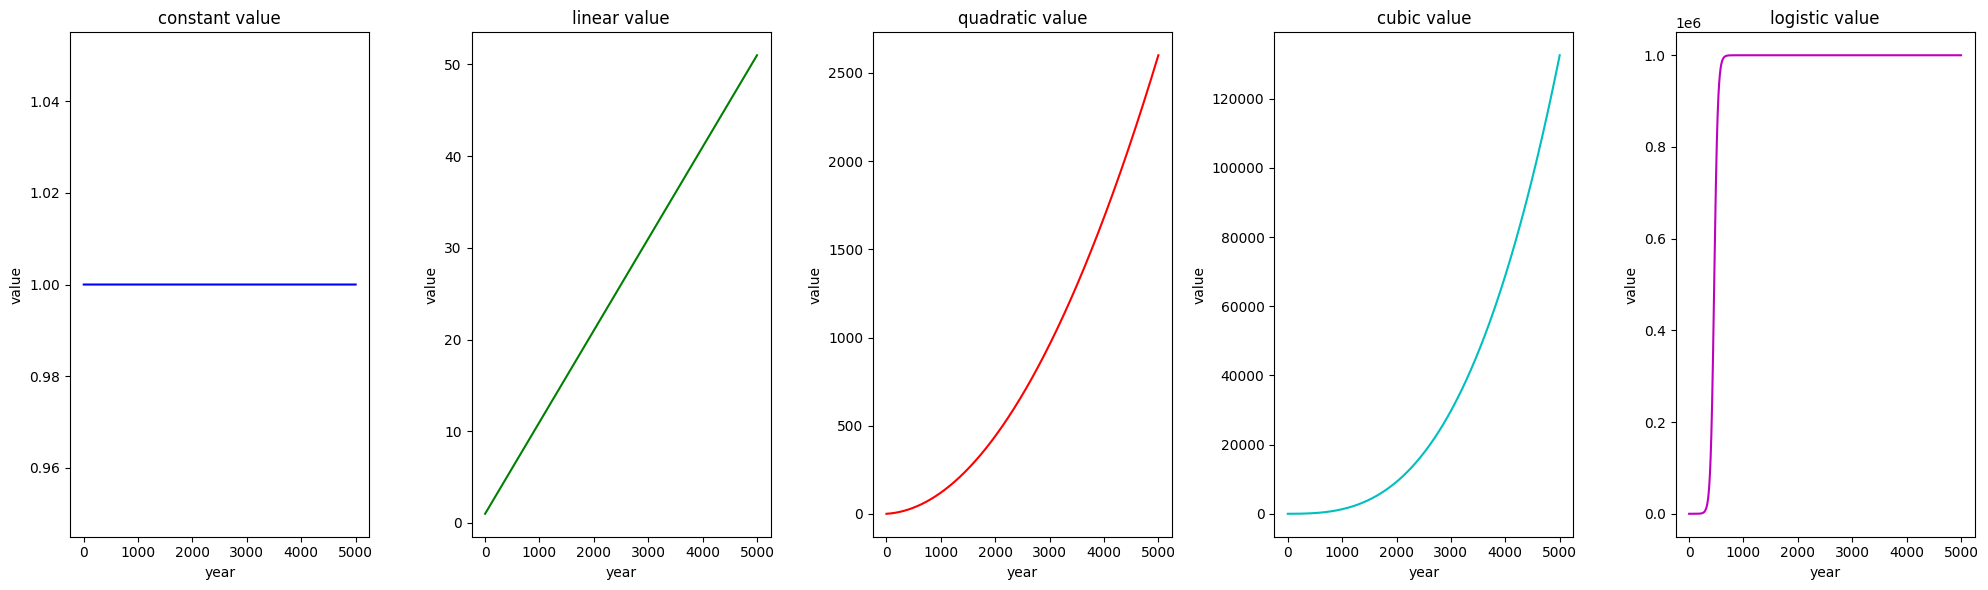

In [7]:
plot_value_scenarios(T=5000,alpha=0.01)

# Different Existential Risk Structures

The defaults in this function are:
- For "constant", the risk is a constant value ```0.0022289477``` for $T$ periods.
- For "top", the risk is ```0.0022289477``` for the first $100$ periods and ```0.0001``` thereafter.
- For "eras", the risk vector alternates between ```0.0022289477``` and ```0.0001``` with eras of different lengths.
- For "exponential_decay", the risk ```r_0=0.0022289477``` decays exponentially towards a tiny risk $r_\infty=$```1e-9``` at the rate ```lambda_val=-0.005```.
- For "custom", the user is prompted to enter their custom risk vector.


In [8]:
def generate_risk_vector(T, r_type="constant", r_high=0.0022289477, r_low=0.0001, eras_periods=None, eras_risks=None, 
                         r_0=0.0022289477, lambda_val=-0.005, r_infty=1e-9, custom_r=None):
    if r_type == "constant":
        r = [r_high for _ in range(T)]
    elif r_type == "top":
        r = [r_high if i < 100 else r_low for i in range(T)]
    elif r_type == "eras":
        if eras_periods is None or eras_risks is None:
            raise ValueError("For 'eras' type, both eras_periods and eras_risks must be provided.")
        r = []
        for i, r_val in zip(eras_periods, eras_risks):
            r.extend([r_val] * i)
    elif r_type == "exponential_decay":
        r = [(r_0 * np.exp(lambda_val * t) + r_infty) for t in range(T)]
    elif r_type == "custom":
        if custom_r is None:
            custom_r = list(map(float, input("Enter your custom r vector separated by spaces: ").split()))
        r = custom_r #this is very flexible, user can run the function with any arbitrary r by setting the option: custom_r = [chosen vector]
    
    return r

# Quick example
T = 150
# lambda_val  used to be -11 for centuries
print(f"For exponential decay: ",generate_risk_vector(T, r_type="exponential_decay"))


# Quick example
T = 1500
eras_periods = [100, 500, 100, T - 700]
eras_risks = [0.0022289477, 0.0001, 0.0022289477, 0.0001]
print(f"For 2 Filters: ",generate_risk_vector(T, "eras",eras_periods=eras_periods,eras_risks=eras_risks))

For exponential decay:  [0.0022289487, 0.002217831776967827, 0.0022067702998205905, 0.0021957639920207853, 0.0021848125784101435, 0.002173915785202754, 0.0021630733399782202, 0.002152284971674845, 0.0021415504105828606, 0.00213086938833768, 0.0021202416379131903, 0.0021096668936150774, 0.002099144891074184, 0.0020886753672398977, 0.0020782580603735776, 0.002067892710042009, 0.002057579057110895, 0.0020473168437383743, 0.0020371058133685778, 0.0020269457107252153, 0.0020168362818051904, 0.0020067772738722547, 0.0019967684354506854, 0.0019868095163190005, 0.001976900267503704, 0.0019670404412730582, 0.001957229791130894, 0.0019474680718104473, 0.001937755039268227, 0.0019280904506779127, 0.0019184740644242867, 0.001908905640097192, 0.001899384938485522, 0.0018899117215712407, 0.0018804857525234313, 0.001871106795692377, 0.0018617746166036684, 0.0018524889819523426, 0.0018432496595970492, 0.0018340564185542487, 0.0018249090289924354, 0.0018158072622263947, 0.0018067508907114826, 0.0017977

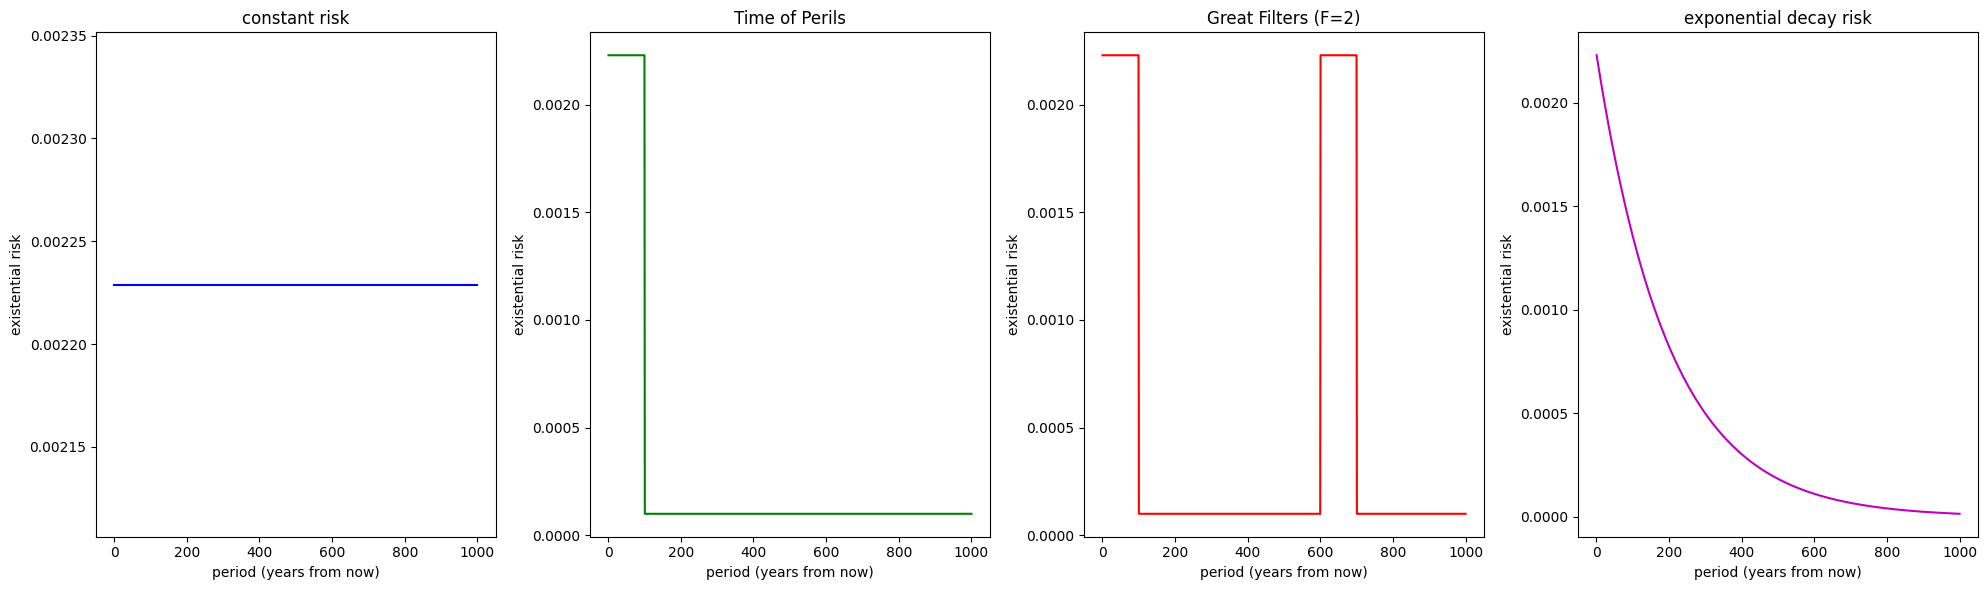

In [9]:
# wrap up the code below in a function
def plot_risk_scenarios(T=1000):
    types = ["constant", "top", "eras", "exponential_decay"]
    colors = ["b", "g", "r", "m"]

    plt.figure(figsize=(20, 6))

    for i, r_type in enumerate(types):
        plt.subplot(1, 4, i + 1)
        r = generate_risk_vector(T, r_type, eras_periods = [100, 500, 100, T - 700], eras_risks = [0.0022289477, 0.0001, 0.0022289477, 0.0001])  
        plt.plot(range(1, T + 1), r, color=colors[i])

        if r_type == 'eras':
            plt.title('Great Filters (F=2)')
        elif r_type == 'top':
            plt.title('Time of Perils')
        elif r_type == 'exponential_decay':
            plt.title('exponential decay risk')
        else:
            plt.title(f"{r_type} risk")

        plt.xlabel("period (years from now)")
        plt.ylabel("existential risk")

    plt.tight_layout()
    plt.show()

plot_risk_scenarios()

# The Expected Value of the World Without Interventions

Let us start with an example. Let us calculate the expected value of the world if risk followed constant risk and value. 

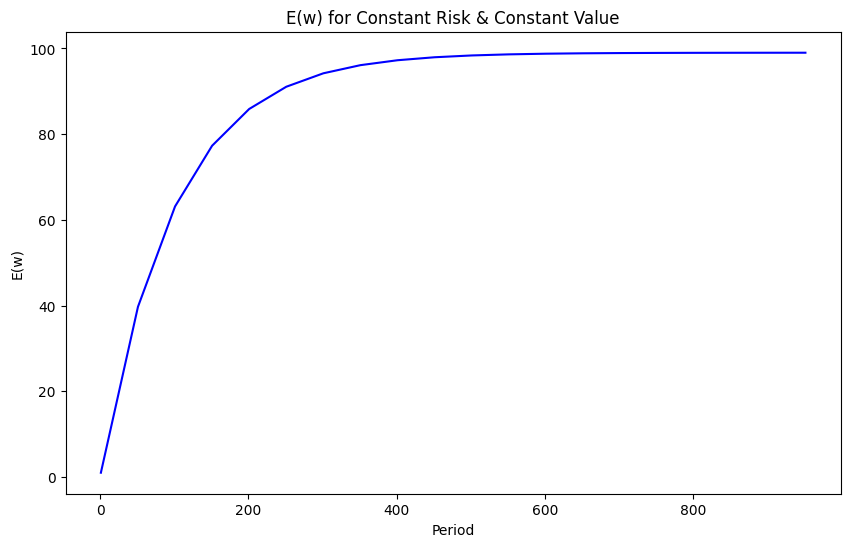

In [10]:
def eg_plotEw_constant_value(T=1000, r_type="constant", r_high=0.0022289477, step=50):   
    # Generate constant value vector and constant risk vector (can set r_high set to 0.01 as an example)
    v_constant = generate_value_vector(T, "constant")

    r_vector = generate_risk_vector(T, r_type, r_high=0.01) # let's use 0.01 for risk since we know (and showed above) that it should converge to 99

    # Calculate Ew for each specified period and store in a list (the step is how often we calculate Ew)
    Ew_list = [calculate_Ew(t, v_constant[:t], r_vector[:t]) for t in range(1, T + 1, step)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, T + 1, step), Ew_list, color='b')
    if r_type == "constant":
        plt.title("E(w) for Constant Risk & Constant Value")
    elif r_type == "top":
        plt.title("E(w) for Time of Perils & Constant Value")
    plt.title("E(w) for Constant Risk & Constant Value")
    plt.xlabel("Period")
    plt.ylabel("E(w)")
    plt.show()
    
eg_plotEw_constant_value()


### Time of Perils under Constant Value

And now under the Time of Perils structure, when the value is constant.

In [11]:
if not skip_execution:
    eg_plotEw_constant_value(T=20000, r_type="top", step=2000) #runtime is about 30s

Performance is an issue, without reaching convergence. A new approach is warranted. We test the running times further below.

In [12]:
if not skip_execution:

    T = 3000
    step = 50  # Calculate E(w) every 50 periods

    # Start the timer
    start_time = time.time()

    # Generate constant value vector and top risk vector 
    v_constant = generate_value_vector(T+1, "constant")
    r_top = generate_risk_vector(T+1, "top")

    # Calculate Ew for each specified period and store in a list
    Ew_list = []
    for t in range(step, T + 1, step):
        Ew = calculate_Ew(t, v_constant[:t], r_top[:t])
        Ew_list.append(Ew)
        
        # Print the run time up until this point
        elapsed_time = time.time() - start_time
        print(f"Elapsed time after {t} periods: {elapsed_time:.2f} seconds")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(step, T + 1, step), Ew_list, color='b')
    plt.title("E(w) for Constant Risk & Constant Value (every 50 periods)")
    plt.xlabel("Period")
    plt.ylabel("E(w)")
    plt.show()

## Modifications to make use of cumulative properties of $E(w)$ and speed up code

For contrast, recall:
```python
def calculate_Ew(T, v, r):
    Ew = 0
    
    for i in range(T):
        prod_term = 1
        
        for j in range(i+1):  
            prod_term *= (1 - r[j])
            
        Ew += prod_term * v[i]
        
    return Ew
```

One possible improvement is to elliminate the second ```for``` loop. We opt for an alternative. The function `calculate_Ew_incremental` is designed to incrementally update the expected value \( E(w) \) and the "product term" (which I'll refer to as ```prod_term``` at each time period \( t \).

Here's the new function definition again for reference:

```python
def calculate_Ew_incremental(prev_Ew, prev_prod_term, v_i, r_i):
    new_prod_term = prev_prod_term * (1 - r_i[-1])
    new_Ew = prev_Ew + new_prod_term * v_i[-1]
    return new_Ew, new_prod_term
```

### Inputs:

1. `prev_Ew`: The previous value of \( E(w) \) up to time \( t-1 \).
2. `prev_prod_term`: The previous value of \( \text{prod\_term} \), which represents the product of \( (1 - r_j) \) terms up to time \( t-1 \).
3. `v_i`: The value vector for time \( t \), which is expected to be a one-element list in the way it's used here.
4. `r_i`: The risk vector for time \( t \), which is also expected to be a one-element list in this context.

### Steps:

1. `new_prod_term = prev_prod_term * (1 - r_i[-1])`: Here, we update \( \text{prod\_term} \) by multiplying it with \( (1 - r_t) \). Since \( r_i \) is expected to be a one-element list, `r_i[-1]` grabs that single element.

2. `new_Ew = prev_Ew + new_prod_term * v_i[-1]`: We update \( E(w) \) by adding \( \text{prod\_term} \times v_t \) to the previous \( E(w) \). Again, because \( v_i \) is expected to be a one-element list, `v_i[-1]` grabs that element.

3. `return new_Ew, new_prod_term`: Finally, we return the updated \( E(w) \) and \( \text{prod\_term} \) for use in the next iteration.

By calculating \( E(w) \) in this incremental way, we save computational time.

In [13]:
# Modified calculate_Ew to handle incremental Ew calculation
def calculate_Ew_incremental(prev_Ew, prev_prod_term, v_i, r_i):
    new_prod_term = prev_prod_term * (1 - r_i[-1]) # r_i[-1] notation for grabbing last element
    new_Ew = prev_Ew + new_prod_term * v_i[-1]
    return new_Ew, new_prod_term

Let us run an example and observe the run times

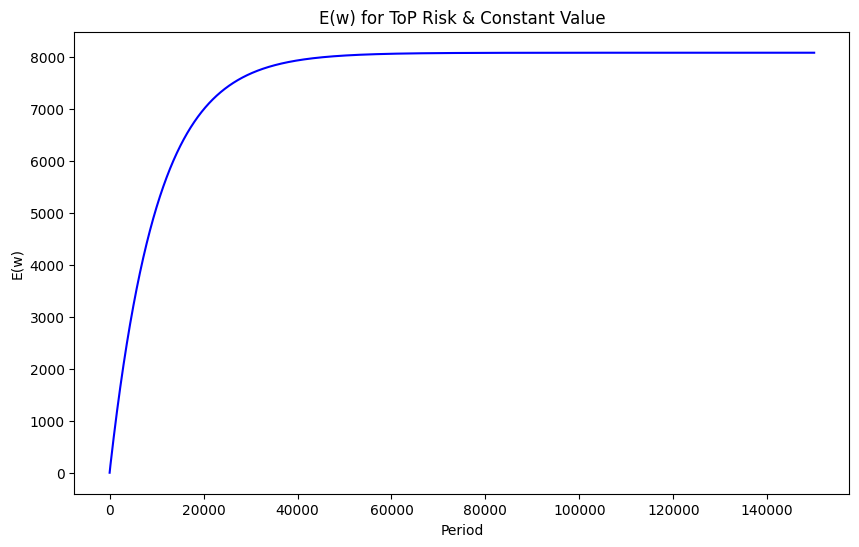

In [14]:
def eg_quicker_ew_top_risk_constant_value():

    # Initial setup
    T = 150000
    step = 1 # what we're recording for our graph
    v_constant = generate_value_vector(T+1, "constant")
    r_top = generate_risk_vector(T+1, "top")

    # Initialize variables
    Ew = 0
    prod_term = 1
    Ew_list = []

    # Start the timer
    start_time = time.time()

    # Loop through each period, but only store the E(w) every 'step' periods
    for t in range(1, T + 1):
        Ew, prod_term = calculate_Ew_incremental(Ew, prod_term, v_constant[t-1:t], r_top[t-1:t])
        
        # If the current period is a multiple of 'step', then store the E(w)
        if t % step == 0:
            Ew_list.append(Ew)
            
            # Print the run time up until this point
            # elapsed_time = time.time() - start_time
            # print(f"Elapsed time after {t} periods: {elapsed_time:.2f} seconds")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(step, T + 1, step), Ew_list, color='b')
    plt.title(f"E(w) for ToP Risk & Constant Value")
    plt.xlabel("Period")
    plt.ylabel("E(w)")
    plt.show()

eg_quicker_ew_top_risk_constant_value() #runtime is about 0.1s. 

# With many loops gone, it's over 300x faster than the previous version and has a much higher T.

## Convergence

It is useful to automate convergence testing of each scenario. Below we create a separate function that checks for convergence based on a given tolerance level. This function will compare the last two \( E(w) \) values and return `True` if they have converged within the tolerance or `False` otherwise. If the function returns `True`, the loop breaks, and the program will print out the period at which it converged.

In [15]:
# Function to check for convergence
def has_converged(new_value, prev_value, tolerance=1e-5):
    if abs(new_value - prev_value) < tolerance:
        return True
    return False

And a quick example of convergence is shown below.

Converged at period 112993, E(w)=8088.628467


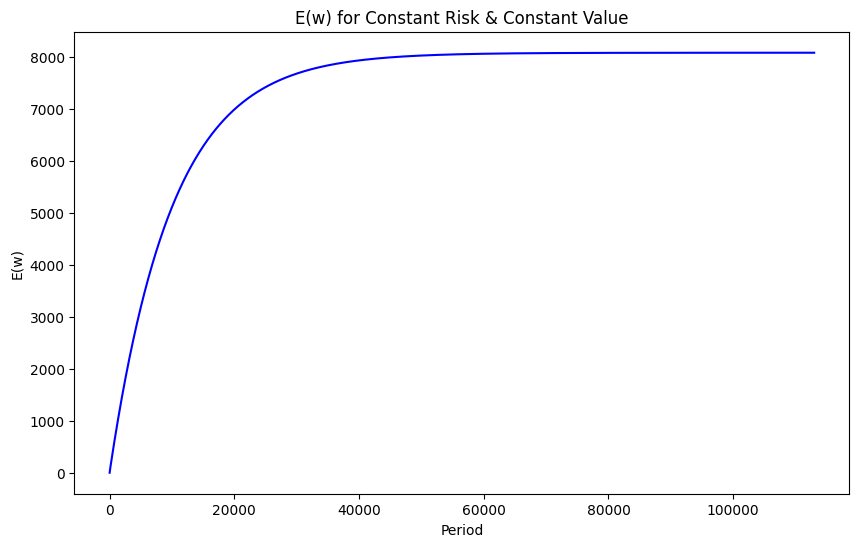

In [16]:
def eg_convergence_plot():
    # Initial setup
    T = 150000
    step = 1
    tolerance = 1e-5  # Convergence tolerance
    v_constant = generate_value_vector(T+1, "constant")
    r_top = generate_risk_vector(T+1, "top")

    # Initialize variables
    Ew = 0
    prod_term = 1
    Ew_list = []
    prev_Ew = None  # Variable to store the previous E(w) for convergence check

    # Start the timer
    start_time = time.time()

    # Loop through each period, but only store the E(w) every 'step' periods
    for t in range(1, T + 1):
        Ew, prod_term = calculate_Ew_incremental(Ew, prod_term, v_constant[t-1:t], r_top[t-1:t])

        # If the current period is a multiple of 'step', then store the E(w)
        if t % step == 0:
            Ew_list.append(Ew)

            # Convergence check
            if prev_Ew is not None:
                if has_converged(Ew, prev_Ew, tolerance):
                    print(f"Converged at period {t}, E(w)={Ew:.6f}")
                    break
            prev_Ew = Ew
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(step, len(Ew_list) * step + 1, step), Ew_list, color='b')
    plt.title(f"E(w) for Constant Risk & Constant Value")
    plt.xlabel("Period")
    plt.ylabel("E(w)")
plt.show()

eg_convergence_plot()

Already, this feels like an insightful result. Suppose that, following the Time of Perils hypothesis, you thought that the world has a 20% chance of ending this century and then it falls to a much lower value of 1% of a catastrophe each century. Then, with constant value, the expected value of the whole of the future is 8,000 years of the value of today's world. Though constant value is an unlikely assumption, this is surprising given that the probability of surviving until an arbitrarily distant future is positive (though of course, it converges to zero, which guarantees convergence of \(E(w)\) overall, as demonstrated in the technical report).

## Grid: Scenarios of E(w)

We are now ready to combine the different cases for both risk and value. We display these various scenarios in a grid.

In [54]:
def grid_risk_titles(r_type, axes=False):
    if not axes:
        if r_type == 'eras':
            plt.title('Great Filters (F=2)')
        elif r_type == 'top':
            plt.title('Time of Perils')
        elif r_type == 'exponential_decay':
            plt.title('exponential decay risk')
        else:
            plt.title(f"{r_type} risk")
    
    if axes:
        if r_type == 'eras':
            axes.set_title('Great Filters (F=2)')
        elif r_type == 'top':
            axes.set_title('Time of Perils')
        elif r_type == 'exponential_decay':
            axes.set_title('exponential decay risk')
        else:
            axes.set_title(f"{r_type} risk")

In [55]:
def Ew_grid(T_value=1000, T_risk=1000, T_middle=300000, tolerance=1e-5, r_types = ["constant", "top", "eras", "exponential_decay"], value_types = ["constant", "linear", "quadratic", "cubic", "logistic"]):
    # Original implementation without has_converged and without calculate_Ew_incremental 
    # (it would take around 24min to complete partial output (only constant and linear value cols) when T=10000 and step=100)

    colors_value = ["b", "g", "r", "c", "m"]
    colors_risk = ["b", "g", "r", "m"]

    plt.figure(figsize=(30, 25))


    T = T_value
    # First row: different value vectors
    for i, v_type in enumerate(value_types):
        plt.subplot(5, 6, i + 2)  # +2 to leave the first subplot empty
        v = generate_value_vector(T, v_type)
        plt.plot(range(1, T + 1), v, color=colors_value[i])
        plt.title(f"{v_type} value")
        plt.xlabel("years")
        plt.ylabel("value")
        
        
    T = T_risk
    # First column: different risk vectors
    for i, r_type in enumerate(r_types):
        plt.subplot(5, 6, (i + 1) * 6 + 1)
        r = generate_risk_vector(T, r_type, eras_periods=[100, 500, 100, T - 700], eras_risks=[0.0022289477, 0.0001, 0.0022289477, 0.0001])
        plt.plot(range(1, T + 1), r, color=colors_risk[i])
        grid_risk_titles(r_type)
        plt.xlabel("years")
        plt.ylabel("risk")

    T = T_middle 
    # Middle plots: Ew for each combination of value and risk
    for i, v_type in enumerate(value_types):
        for j, r_type in enumerate(r_types):
            plt.subplot(5, 6, (j + 1) * 6 + (i + 2))  # +2 to skip the first column
            v = generate_value_vector(T+1, v_type)
            r = generate_risk_vector(T+1, r_type, eras_periods=[100, 500, 100, T - 700], eras_risks=[0.0022289477, 0.0001, 0.0022289477, 0.0001])

            Ew = 0
            prod_term = 1
            Ew_list = []
            prev_Ew = None
            step = 1 # Calculate E(w) every "step" periods (previously tweaked to 1000 to accelerate the process during tests)

            for t in range(1, T + 1):
                Ew, prod_term = calculate_Ew_incremental(Ew, prod_term, v[t-1:t], r[t-1:t])

                if t % step == 0:
                    Ew_list.append(Ew)

                    if prev_Ew is not None and has_converged(Ew, prev_Ew, tolerance):
                        break
                    
                    prev_Ew = Ew

            plt.plot(range(step, len(Ew_list) * step + 1, step), Ew_list, color=colors_risk[j])
            plt.title(f"{r_type} r & {v_type} v")
            plt.xlabel("years")
            plt.ylabel("E(w)")

    plt.tight_layout()
    plt.show() 
    #runtimes:
    # 17s for T = 1 million 
    # 7s for T = 300000


Let us obtain the grid. Consider a long cap $T=300,000$, or until convergence with high sensitivity is reached. Recall $E(w)$ at year $y$ is cumulative, it's the $E(w)$ if the age of the universe was $T=y$.

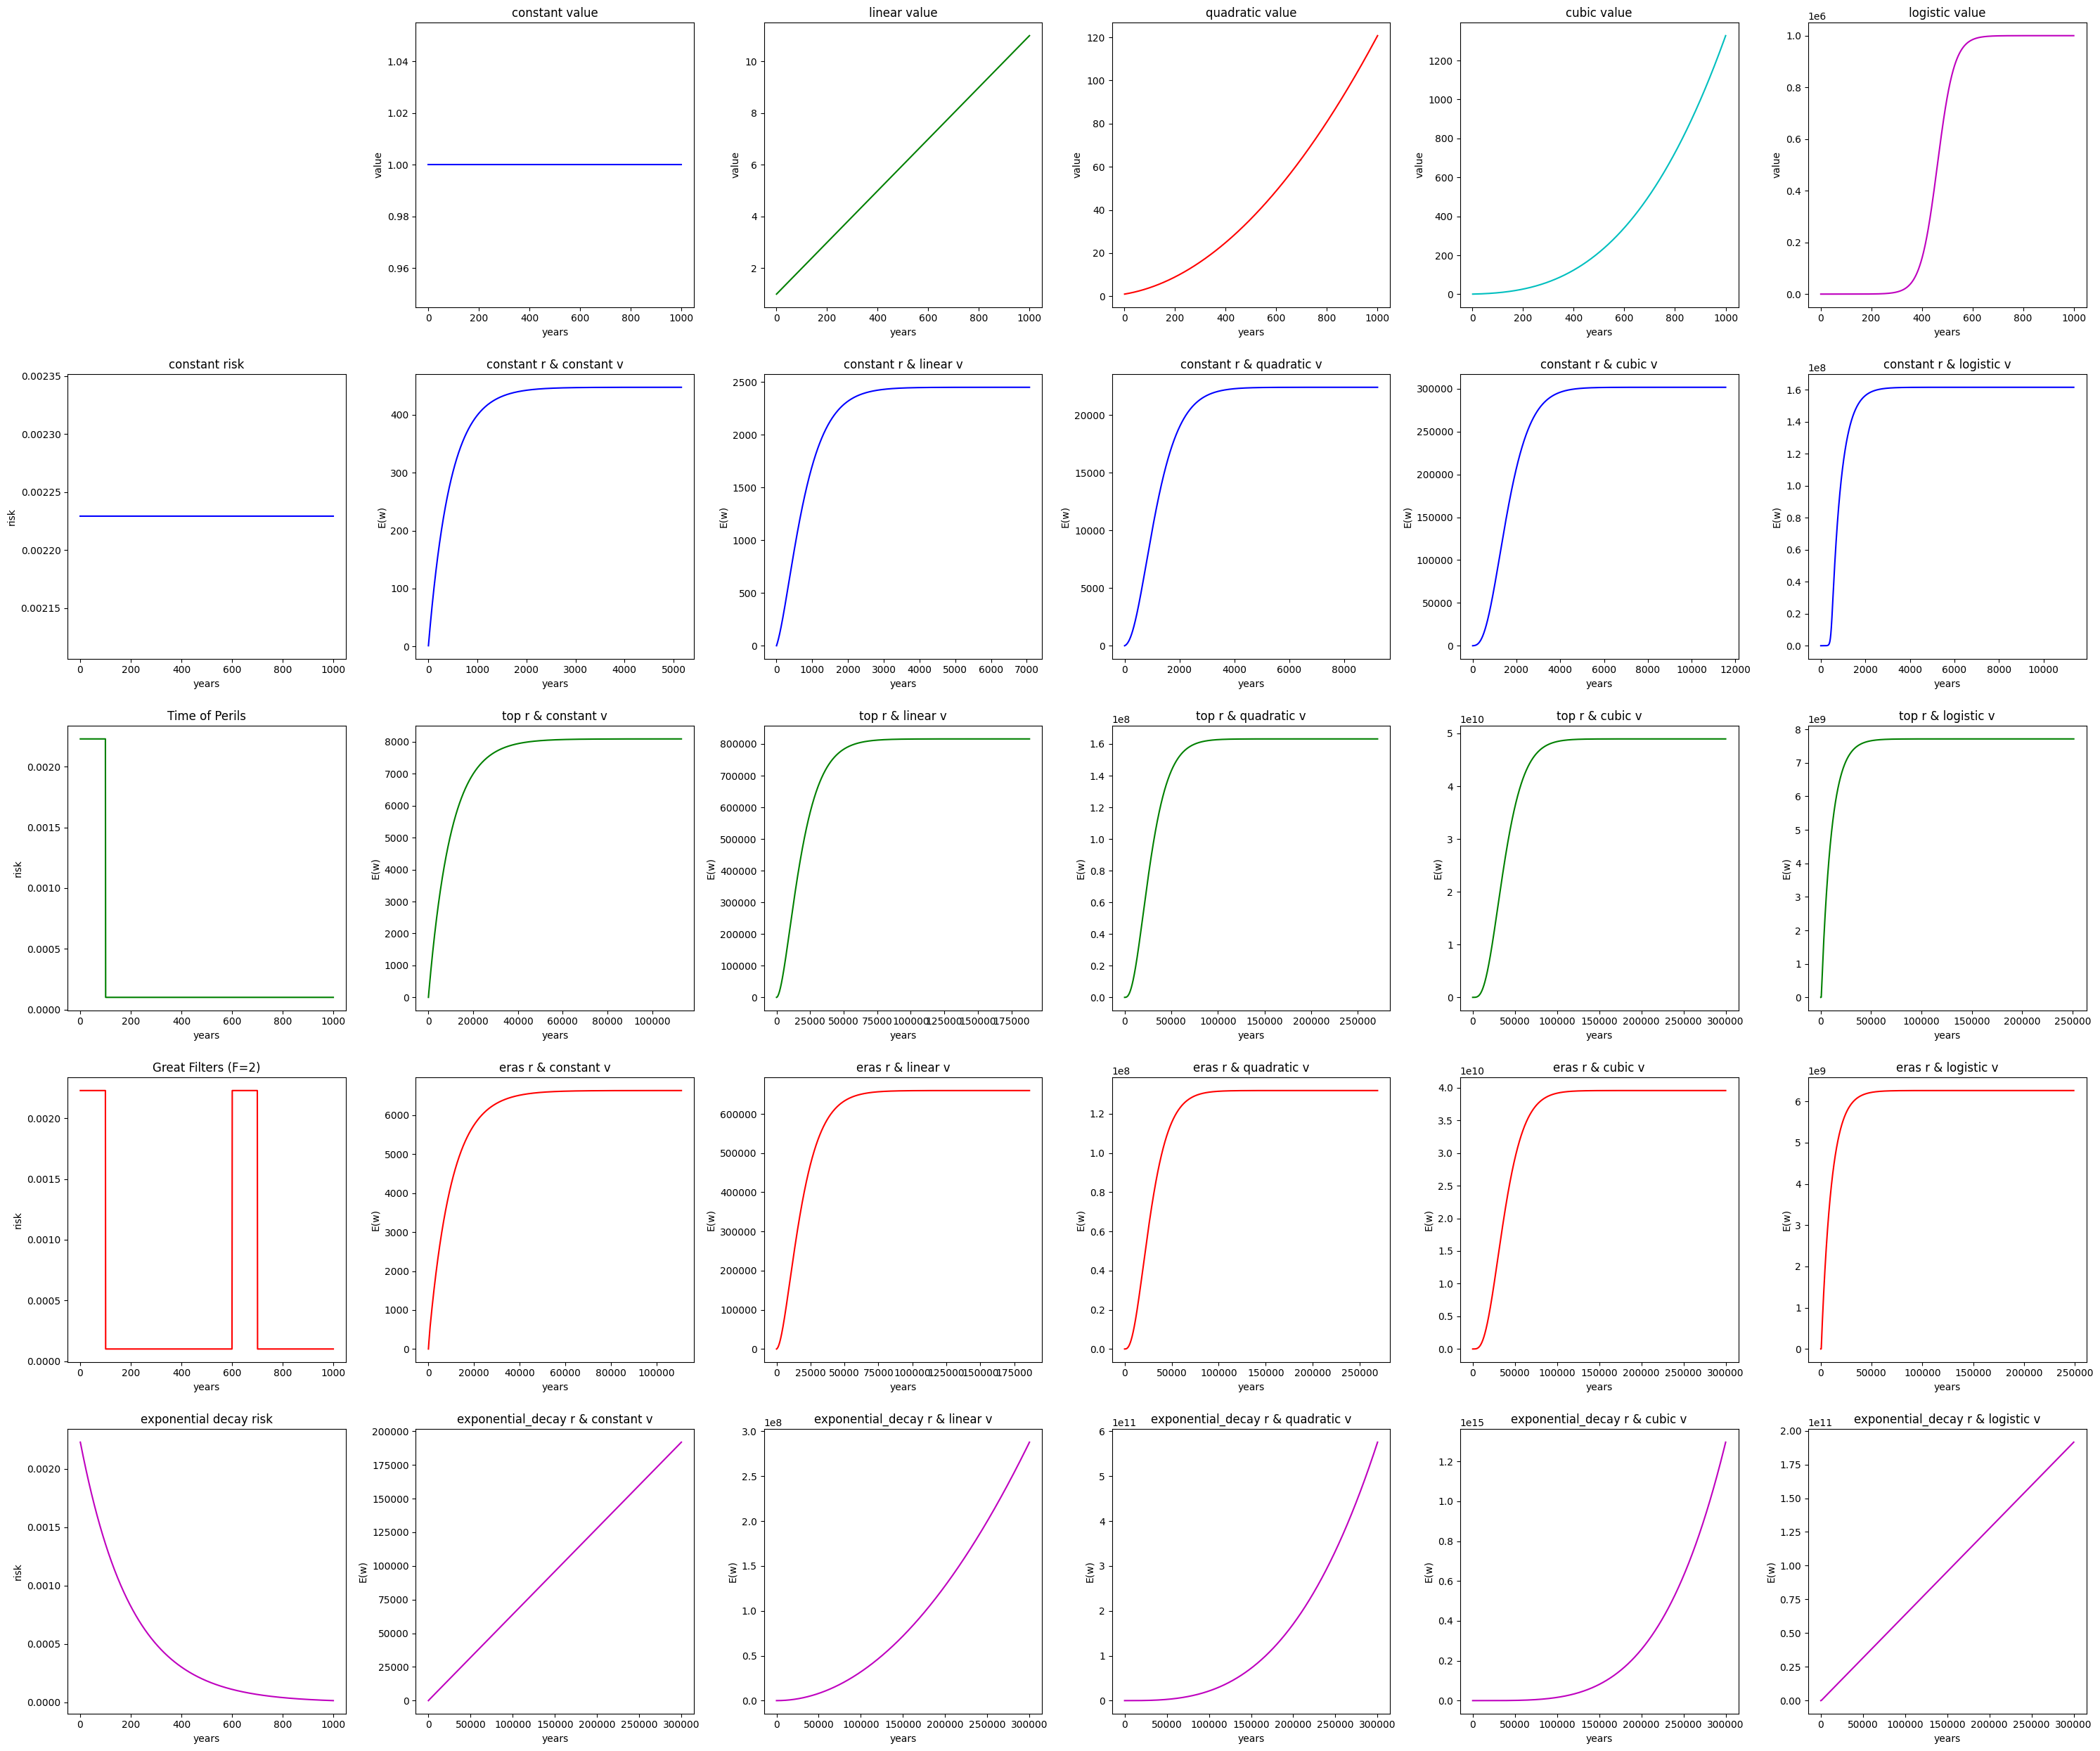

In [56]:
Ew_grid()

Only do exponential decay row, with a 10 million cap.

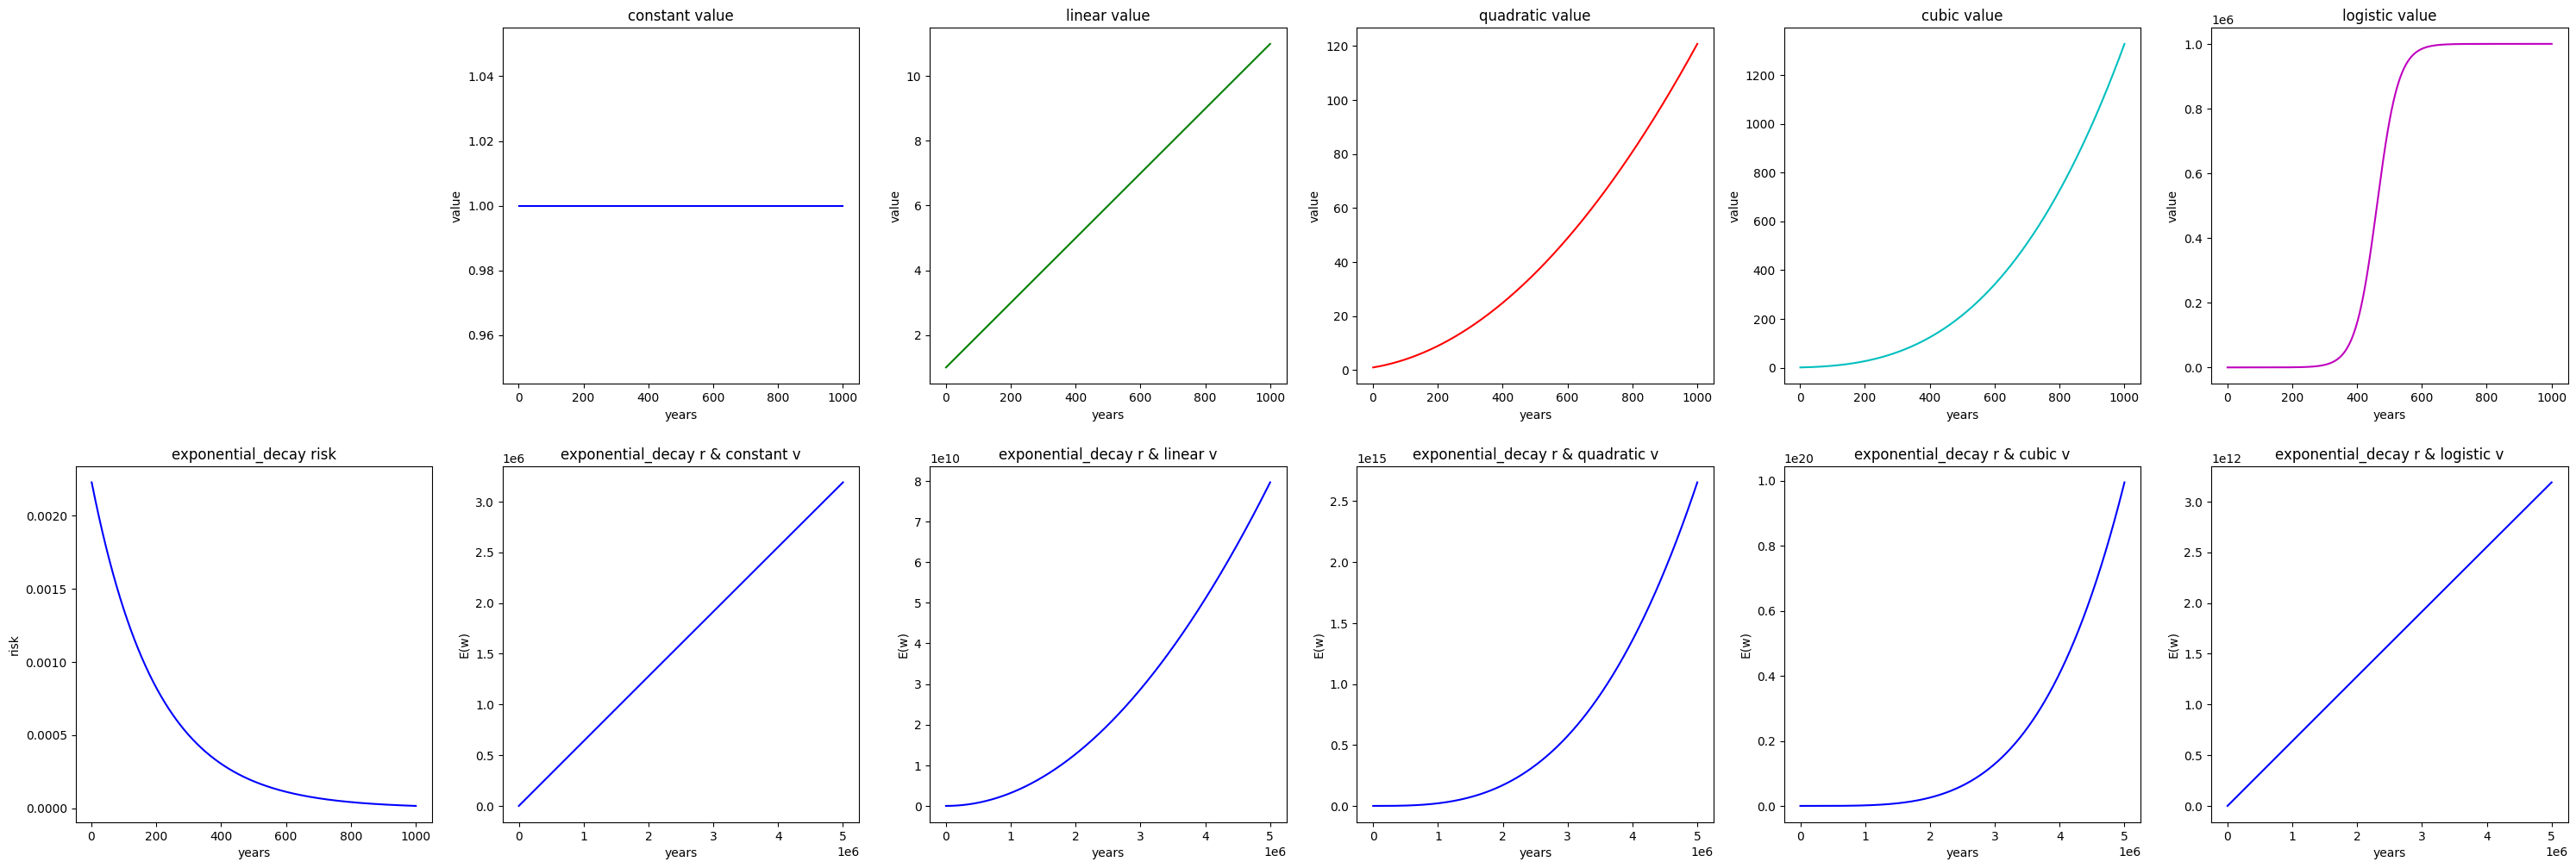

In [27]:
# Only do exponential decay row, with a 10 million cap.

Ew_grid(T_middle=5000000, r_types = ["exponential_decay"])  # runtime is about 40s
 

Convergence is nowhere to be found for exponentially decaying risk.

# The Value of Existential Risk Mitigation

## Risk after mitigation action $M$

We now define a function that returns the $r^\prime$ risk vector after performing a mitigating action $M$.

Parameters:
- r (list): The original risk vector.
- f (float): The mitigation factor, between 0 and 1.
- P (int): The persistence of the mitigation, in periods.

Returns:
- list: The modified risk vector.

In [28]:
def apply_mitigation(r, f, P):
    # Modify a risk vector by applying a mitigation action.
    
    # Copy the original risk vector to avoid modifying it directly
    r_modified = r.copy()
    
    # Apply the mitigation factor for the first P periods
    for i in range(min(P, len(r))): # min in case P exceeds length of r
        r_modified[i] = r[i] * (1 - f)
        
    return r_modified

# Example usage:
original_risk = generate_risk_vector(r_high=0.1, r_type="constant", T=100)
mitigated_risk = apply_mitigation(original_risk, 0.2, 5) # This will reduce the risk by 20% for the first 5 periods.


# Print the original and mitigated risk vectors
print("Original risk vector for the first 10 periods:", [round(r, 8) for r in original_risk[:10]])
print("Mitigated risk vector for the first 10 periods:", [round(r, 8) for r in mitigated_risk[:10]])


Original risk vector for the first 10 periods: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Mitigated risk vector for the first 10 periods: [0.08, 0.08, 0.08, 0.08, 0.08, 0.1, 0.1, 0.1, 0.1, 0.1]


To save computational effort, it will be useful have the history of ```Ew```s for each period, so we will return that as well in a new function.

In [29]:
def calculate_Ew_vector_up_to_t (t, v, r):
    Ew = 0
    prod_term = 1
    Ew_list = []
    prev_Ew = None

    for i in range(1, t + 1):
        Ew, prod_term = calculate_Ew_incremental(Ew, prod_term, v[i-1:i], r[i-1:i])
        Ew_list.append(Ew)
    return Ew_list

# Example usage

T = 15
v_constant = generate_value_vector(T, "constant")
r_constant = generate_risk_vector(T, "constant")

print(f"The length of the E(w) vector up to period {T} is: {len(calculate_Ew_vector_up_to_t(T, v_constant, r_constant))}")
print(f"The length of the v_constant vector up to period {T} is: {len(v_constant)}")
print(f"The length of the r_constant vector up to period {T} is: {len(r_constant)}")

print(f"The E(w) vector up to period {T} is: {calculate_Ew_vector_up_to_t(T, v_constant, r_constant)}")

The length of the E(w) vector up to period 15 is: 15
The length of the v_constant vector up to period 15 is: 15
The length of the r_constant vector up to period 15 is: 15
The E(w) vector up to period 15 is: [0.9977710523, 1.9933181251078493, 2.9866461755575218, 3.9777601497337987, 4.966664982696898, 5.953365598507045, 6.937866910248993, 7.920173820056487, 8.90029121913667, 9.878223987794446, 10.853976995456765, 11.82755510069689, 12.798963151258567, 13.768205984080184, 14.735288425318842]


Given the mitigated risk vector, we can now calculate the mitigated E(M) up to each period (i.e. the value of mitigation if the universe suddenly ended $t$ periods from now). Our function calculates $ E(M) = E(w \,|\, M) - E(w) $. In this function, we will utilize the previously defined helper functions to compute $ E(w) $ with and without mitigation and then return the difference.

In [30]:
def expected_value_vector_of_M_up_to_t(T, r_type = "constant", v_type = "constant" , f = 0.5, P = 5,
                                       eras_periods = [100, 500, 100, T - 700], eras_risks = [0.0022289477, 0.0001, 0.0022289477, 0.0001]):
    
    v = generate_value_vector(T, v_type)
    r_original = generate_risk_vector(T, r_type=r_type, eras_periods=eras_periods, eras_risks=eras_risks)
    
    r_mitigated = apply_mitigation(r_original, f, P)
    
    Ew_original_vector = calculate_Ew_vector_up_to_t(T, v, r_original)
    Ew_mitigated_vector = calculate_Ew_vector_up_to_t(T, v, r_mitigated)

    # Calculate the difference E(M) = E(w | M) - E(w) for each period
    expected_value_diff_vector = np.array(Ew_mitigated_vector) - np.array(Ew_original_vector)
    
    # Test: print lengths of vectors
    # print(f"Length of Ew_original_vector: {len(Ew_original_vector)}")
    # print(f"Length of Ew_mitigated_vector: {len(Ew_mitigated_vector)}")
    # print(f"Length of expected_value_diff_vector: {len(expected_value_diff_vector)}")
    # print(f"Length of v: {len(v)}")
    # print(f"Length of r_original: {len(r_original)}")
    # print(f"Length of r_mitigated: {len(r_mitigated)}")

    return expected_value_diff_vector

# Example usage
T=15
result = expected_value_vector_of_M_up_to_t(T)
print("\n")
print(f"The expected value of M up to period {T} is: {result}")

# Can also see directly
v = generate_value_vector(T, v_type="constant")
r_original = generate_risk_vector(T, r_type="constant")
r_mitigated = apply_mitigation(r_original, f=0.5, P=5)
Ew_original_vector = calculate_Ew_vector_up_to_t(T, v, r_original)
Ew_mitigated_vector = calculate_Ew_vector_up_to_t(T, v, r_mitigated)
print(f"The original E(w) vector up to period {T} is: {Ew_original_vector}")
print(f"The mitigated E(w) vector up to period {T} is: {Ew_mitigated_vector}")

print("\n")

# Quick coomparison
print(f"The expected value of M by period {6} is: {result[5]}")
print(f"The original E(w) by period {6} is: {Ew_original_vector[5]}")
print(f"The mitigated E(w) by period {6} is: {Ew_mitigated_vector[5]}")
print(f"The difference between the mitigated and original E(w) by period {6} is: {Ew_mitigated_vector[5] - Ew_original_vector[5]}")
print(f"This is equal to the expected value of M by period {6}: {result[5]==Ew_mitigated_vector[5] - Ew_original_vector[5]}")




The expected value of M up to period 15 is: [0.00111447 0.0033397  0.00667195 0.01110753 0.01664273 0.0221656
 0.02767615 0.03317443 0.03866045 0.04413424 0.04959583 0.05504524
 0.06048251 0.06590766 0.07132072]
The original E(w) vector up to period 15 is: [0.9977710523, 1.9933181251078493, 2.9866461755575218, 3.9777601497337987, 4.966664982696898, 5.953365598507045, 6.937866910248993, 7.920173820056487, 8.90029121913667, 9.878223987794446, 10.853976995456765, 11.82755510069689, 12.798963151258567, 13.768205984080184, 14.735288425318842]
The mitigated E(w) vector up to period 15 is: [0.99888552615, 1.9966578205019623, 2.993318123723615, 3.988867675099994, 4.983307712534985, 5.975531195135747, 6.96554306348708, 7.953348247161479, 8.938951664743678, 9.922358223855145, 10.903572821178516, 11.882600342481977, 12.859445662643592, 13.834113645675577, 14.806609144748519]


The expected value of M by period 6 is: 0.02216559662870221
The original E(w) by period 6 is: 5.953365598507045
The mit

We now have all the necessary ingredients to compare the value of $M$, let's observe side-by-side the value of worlds with and without the mitigation action.

We write a function where we can specify the mitigation factor and we plot the value of the world without mitigation (as the benchmark) and with mitigation. For the mitigation case we plot the value of the world for different values of P (the number of periods for which the mitigation is applied). In particular, we plot P = 1,5,50,500,T. We use the constant risk vector and the constant value vector for this example.


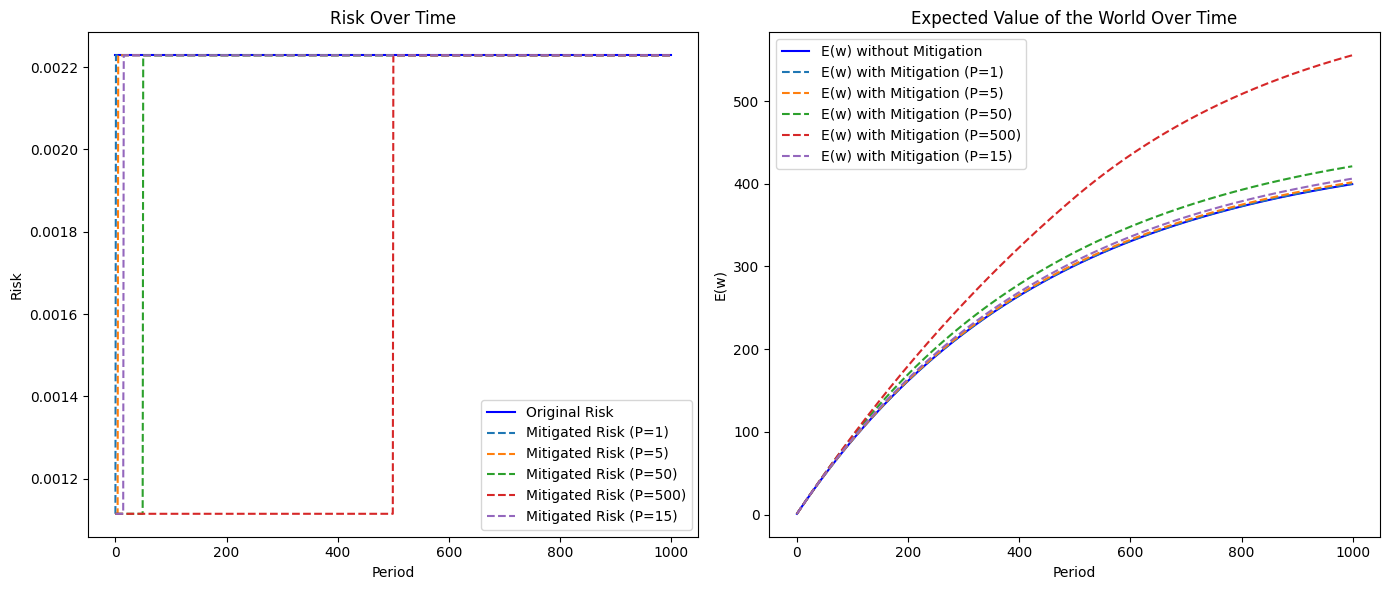

In [31]:
def plot_mitigated_vs_unmitigated_Ew(T, f, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant"):
    # Initialize plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300) # for high resolution
    
    # Generate original risk vector
    r_original = generate_risk_vector(T, r_type=r_type)
    
    # Plot risk vectors
    axes[0].plot(r_original, label="Original Risk", color="blue")
    for P in Ps:
        r_mitigated = apply_mitigation(r_original, f, P)
        axes[0].plot(r_mitigated, linestyle="--", label=f"Mitigated Risk (P={P})")
    
    axes[0].set_title("Risk Over Time")
    axes[0].set_xlabel("Period")
    axes[0].set_ylabel("Risk")
    axes[0].legend()
    
    # Generate original value vector
    v = generate_value_vector(T, v_type=v_type)
    
    # Calculate and plot E(w) without mitigation
    Ew_original_vector = calculate_Ew_vector_up_to_t(T, v, r_original)
    axes[1].plot(Ew_original_vector, label="E(w) without Mitigation", color="blue")
    
    # Calculate and plot E(w) with mitigation
    for P in Ps:
        r_mitigated = apply_mitigation(r_original, f, P)
        Ew_mitigated_vector = calculate_Ew_vector_up_to_t(T, v, r_mitigated)
        axes[1].plot(Ew_mitigated_vector, linestyle="--", label=f"E(w) with Mitigation (P={P})")
    
    axes[1].set_title("Expected Value of the World Over Time")
    axes[1].set_xlabel("Period")
    axes[1].set_ylabel("E(w)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
T=1000
plot_mitigated_vs_unmitigated_Ew(T, 0.5)


Tests:

- It is useful to cross check these results against closed form solution for constant value and constant risk 

- It should match and the values that the graphs converge to. 

- Let us first check the closed form solution for constant value and constant risk. We know that the expected value of the world is given by the following formula:

- What about the other cases?

Converged at period 5160, E(w) with P=1 is 448.137724
Converged at period 5162, E(w) with P=5 is 450.132158
Converged at period 5185, E(w) with P=50 is 471.967128
Converged at period 5410, E(w) with P=500 is 639.382211
Converged at period 5660, E(w) with P=1000 is 749.177320


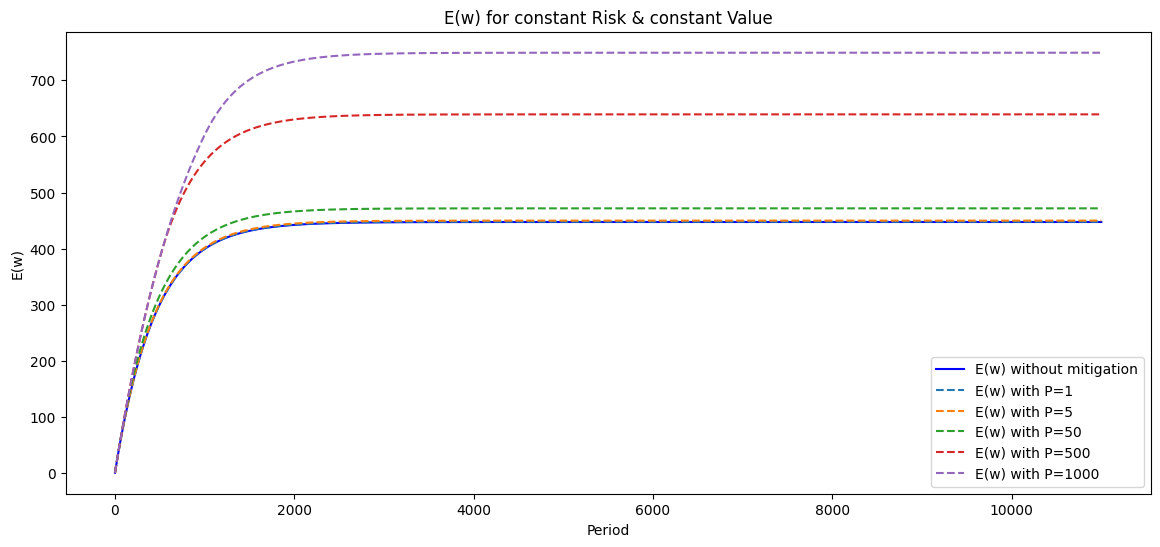

In [32]:
# Now we write code that gives us the same plots but until convergence by using the has_converged function

def plot_mitigated_vs_unmitigated_Ew_convergence(T, f=0.5, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant", tolerance=1e-5):
    # Initialize variables
    Ew_original = 0
    prod_term_original = 1
    Ew_list_original = []
    prev_Ew_original = None

    Ew_mitigated = {P: 0 for P in Ps}
    prod_term_mitigated = {P: 1 for P in Ps}
    Ew_list_mitigated = {P: [] for P in Ps}
    prev_Ew_mitigated = {P: None for P in Ps}

    converged_flags = {P: False for P in Ps} # Flags to indicate if E(w) has converged for each P

    # Generate the constant value and risk vectors
    v = generate_value_vector(T+1, v_type=v_type)
    r_original = generate_risk_vector(T+1,r_type=r_type)

    for t in range(1, T + 1):
        # Update original E(w) values
        Ew_original, prod_term_original = calculate_Ew_incremental(Ew_original, prod_term_original, v[t-1:t], r_original[t-1:t])

        # Update mitigated E(w) values for each P
        for P in Ps:
            r_mitigated = apply_mitigation(r_original, 0.5, P)
            Ew_mitigated[P], prod_term_mitigated[P] = calculate_Ew_incremental(Ew_mitigated[P], prod_term_mitigated[P], v[t-1:t], r_mitigated[t-1:t])

        # Store and check the E(w)
        Ew_list_original.append(Ew_original)

        for P in Ps:
            Ew_list_mitigated[P].append(Ew_mitigated[P])

            if prev_Ew_mitigated[P] is not None and not converged_flags[P]:
                if has_converged(Ew_mitigated[P], prev_Ew_mitigated[P], tolerance):
                    print(f"Converged at period {t}, E(w) with P={P} is {Ew_mitigated[P]:.6f}")
                    converged_flags[P] = True

        prev_Ew_original = Ew_original
        for P in Ps:
            prev_Ew_mitigated[P] = Ew_mitigated[P]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(range(1, len(Ew_list_original) + 1), Ew_list_original, label="E(w) without mitigation", color='b')

    for P in Ps:
        plt.plot(range(1, len(Ew_list_mitigated[P]) + 1), Ew_list_mitigated[P], linestyle="--", label=f"E(w) with P={P}")

    plt.title(f"E(w) for {r_type} Risk & {v_type} Value")
    plt.xlabel("Period")
    plt.ylabel("E(w)")
    plt.legend()
    plt.show()
    
# Example usage
T=11000
plot_mitigated_vs_unmitigated_Ew_convergence(T)


This graph seems to suggest that halving the risk globally doubles total E(w). Is there a rule of this? cf with closed form solution in thorstad

Let us do the same exercise with ToP risk vector and constant value vector


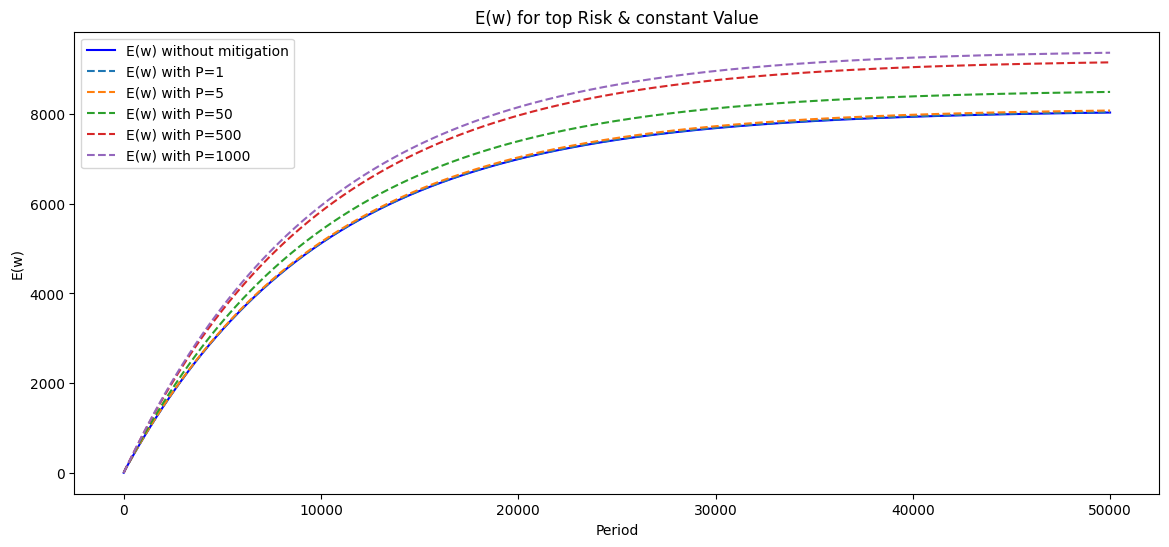

In [55]:
# Let us do the same exercise with Top risk vector and constant value vector

plot_mitigated_vs_unmitigated_Ew_convergence(T=50000, r_type="top", v_type="constant")

The relative difference with respect to $E(w)$ in top & constnat value is much smaller, but the absolute difference is much larger. This is because the value of the world is much larger in the ToP case.

Let us plot the expected value of $M$ for different values of $P$. We will use the constant value vector and the constant risk vector.

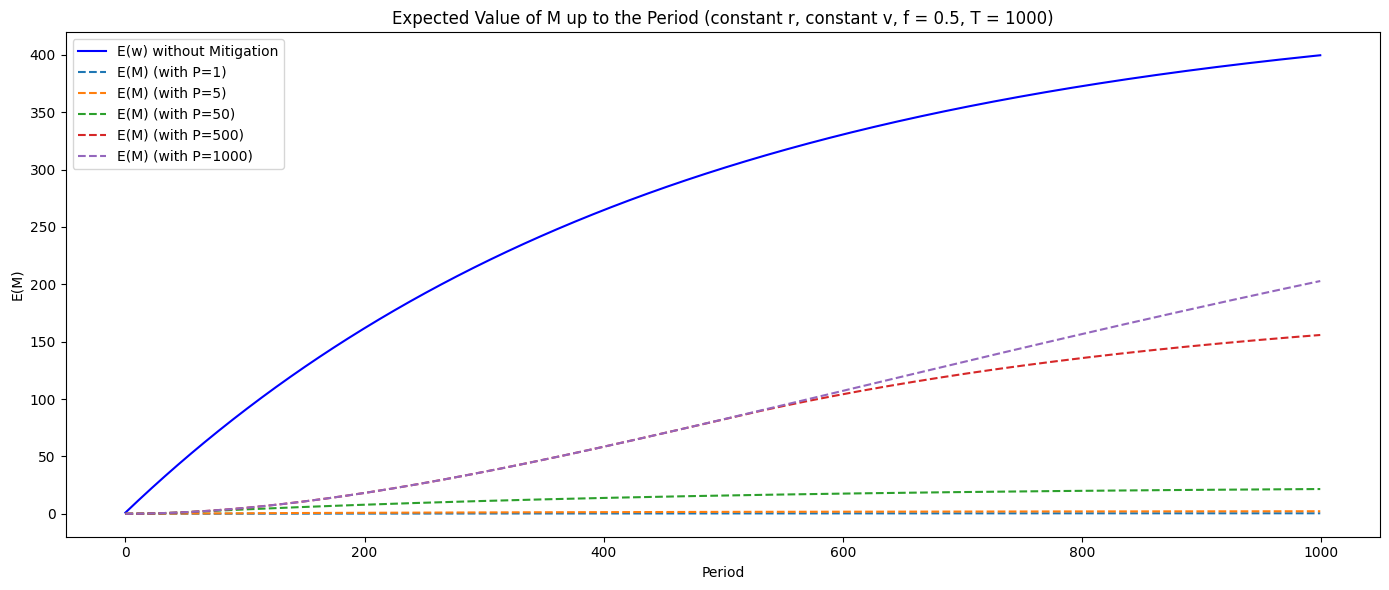

In [33]:
# Use expected_value_vector_of_M_up_to_t to calculate the expected value of M up to period T for each P then plot the results in one graph

def plot_expected_value_of_M_up_to_t(T, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant", f=0.5):
    # Initialize plot
    fig, axes = plt.subplots(1, 1, figsize=(14, 6))
    
    # Generate original risk vector
    r_original = generate_risk_vector(T, r_type=r_type)
    
    # Generate original value vector
    v = generate_value_vector(T, v_type=v_type)
    
    # Calculate and plot E(w) without mitigation
    Ew_original_vector = calculate_Ew_vector_up_to_t(T, v, r_original)
    axes.plot(Ew_original_vector, label="E(w) without Mitigation", color="blue")
    
    #  Plot expected valye of M up to period T for each P
    for P in Ps:
        Em_vector = expected_value_vector_of_M_up_to_t(T, r_type, v_type, f=f, P=P)
        axes.plot(Em_vector, linestyle="--", label=f"E(M) (with P={P})")
    
    axes.set_title(f"Expected Value of M up to the Period ({r_type} r, {v_type} v, f = {f}, T = {T})")
    axes.set_xlabel("Period")
    axes.set_ylabel("E(M)")
    axes.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
T=1000
plot_expected_value_of_M_up_to_t(T, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant")

This example bears highlighting. In a sense, we can already see that persistence will be a major factor in determining how valuable a mitigation action is. If the mitigation action is not persistent, then it is not very valuable. This is because the risk of extinction will return to its original value after the mitigation action is over.

In the plot above we can take $E(w)$ as the benchmark amount of value available in expectation given our present circumstances. With that in mind, when $P=1,5,50$ the value of $M$ is simply not on the scale of $E(w)$, let alone on an _astronomical_ scale. However, when $P=500, T$ the value of $M$ is on the order of magnitude of of $E(w)$. Next, let us examine convergence and then test a different case: Great Filters, with $F=2$.

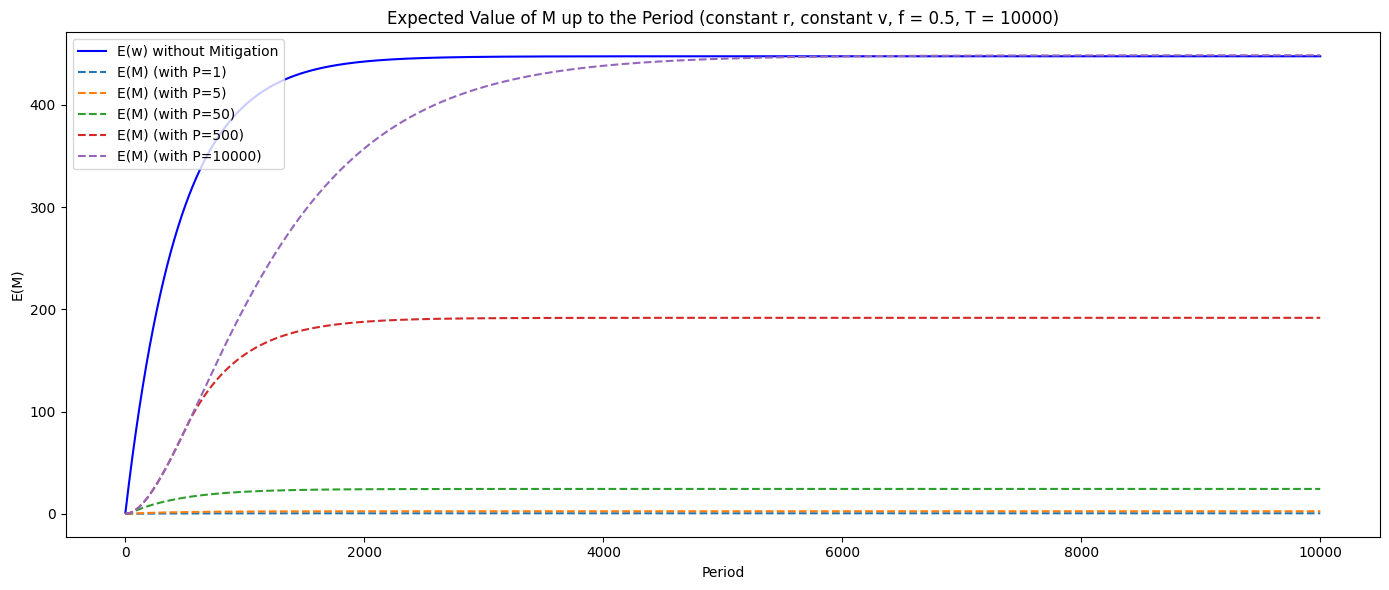

In [34]:
T=10000
plot_expected_value_of_M_up_to_t(T, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant")

The graph above would suggest that the only reason global risk reduction isn't astronomically valuable is because it E(w) wasn't astronomically valuable in the first place. Otherwise, at least in this case, it seems like $M$ with permanent effects would deserve as much counterfactual credit as the entire expected value of the world itself.

Now let us fix the persistence $P$ and try with different values of $f$.

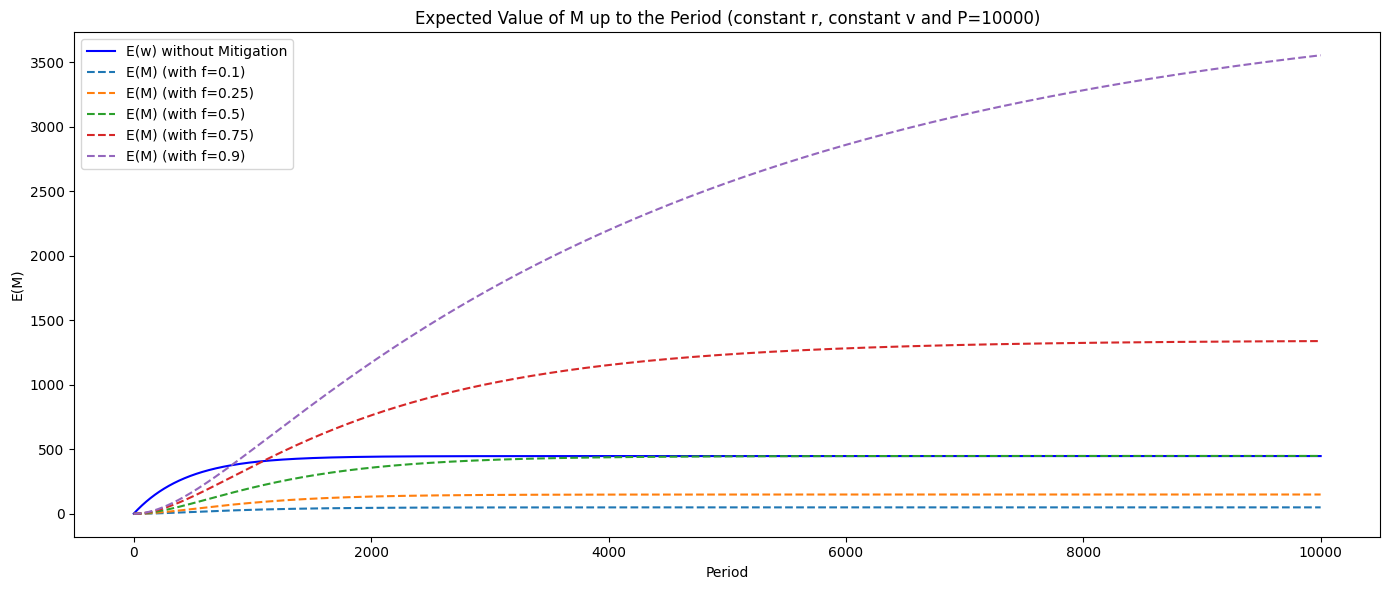

Final E(M) values for each f: [49.849132487922645, 149.54736776806237, 448.6293281073746, 1339.1189960537124, 3555.081552227348]
Ratio of E(M) to E(w) for f=0.1: 0.11135932333620967
Ratio of E(M) to E(w) for f=0.25: 0.3340779036705903
Ratio of E(M) to E(w) for f=0.5: 1.0022051721545928
Ratio of E(M) to E(w) for f=0.75: 2.991494090761462
Ratio of E(M) to E(w) for f=0.9: 7.941792691317049


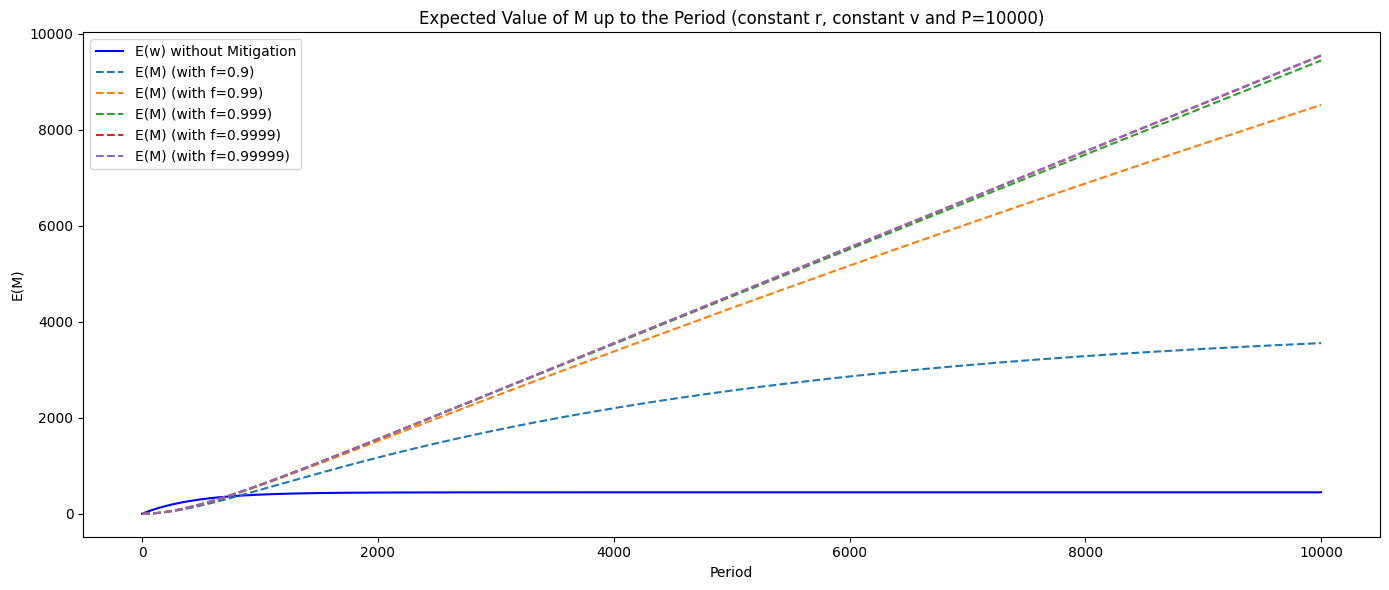

Final E(M) values for each f: [3555.081552227348, 8516.160965572653, 9441.722712194562, 9541.220222769885, 9551.243297506639]
Ratio of E(M) to E(w) for f=0.9: 7.941792691317049
Ratio of E(M) to E(w) for f=0.99: 19.024481976254613
Ratio of E(M) to E(w) for f=0.999: 21.092119358603593
Ratio of E(M) to E(w) for f=0.9999: 21.31438953459893
Ratio of E(M) to E(w) for f=0.99999: 21.336780351945723


In [36]:
#Try again with differnt values of f
# We plot the expected value of M up to period T for each f
# This time we use the same P=T for all f

def plot_expected_value_of_M_up_to_t_different_fs(T, fs=[0.1, 0.3, 0.5, 0.7, 0.9], r_type="constant", v_type="constant", r_high=0.0022289477, P=T, hide_benchmark=False, hide_ratios=False):
    # Initialize plot
    fig, axes = plt.subplots(1, 1, figsize=(14, 6))
    
    # Empty list for storing final E(M) values for each f
    final_Em = []
    
    # Generate original risk vector
    r_original = generate_risk_vector(T, r_type=r_type)
    
    # Generate original value vector
    v = generate_value_vector(T, v_type=v_type)
    
    # Calculate and plot E(w) without mitigation
    Ew_original_vector = calculate_Ew_vector_up_to_t(T, v, r_original)
    if not hide_benchmark: # If hide_benchmark is False, then plot the benchmark E(w) too
        axes.plot(Ew_original_vector, label="E(w) without Mitigation", color="blue")
    
    #  Plot expected valye of M up to period T for each f
    for f in fs:
        Em_vector = expected_value_vector_of_M_up_to_t(T, r_type, v_type, f=f, P=P)
        axes.plot(Em_vector, linestyle="--", label=f"E(M) (with f={f})")
        final_Em.append(Em_vector[-1])
    
    axes.set_title(f"Expected Value of M up to the Period ({r_type} r, {v_type} v and P={P})")
    axes.set_xlabel("Period")
    axes.set_ylabel("E(M)")
    axes.legend()
    
    plt.tight_layout()
    plt.show()
    
    # It's interesting to calculate some ratios of E(M) wrt E(w) for each f
    print(f"Final E(M) values for each f: {final_Em}")
    if not hide_ratios:
        for i, f in enumerate(fs):
            print(f"Ratio of E(M) to E(w) for f={f}: {final_Em[i]/Ew_original_vector[-1]}")
    

# Example usage
T=10000
plot_expected_value_of_M_up_to_t_different_fs(T, fs=[0.1, 0.25, 0.5, 0.75, 0.9], r_type="constant", v_type="constant")

# And with really high f values
# T=5000000 #30s to run
T=10000
plot_expected_value_of_M_up_to_t_different_fs(T, fs=[0.9, 0.99, 0.999, 0.9999, 0.99999], r_type="constant", v_type="constant")

It's interesting to see that the $f=0.5$ case converges to the benchmark. That is, the value of the mitigation action with $P=T$ is the same as $E(w)$ the value of the future without mitigation. 

- To do: Let us quickly check whether that depends on the risk level.
    - This requires altering functions above so they can take customised r_high, which would be good. They should have all the options for full customisability.

From Thorstad, we know that $E(M)$ in the $P=1$ case when risk and value are constant is given by $E(M) = fv$. That is, value should be capped at $v$ as $f \to 1$. The plots below confirm this.

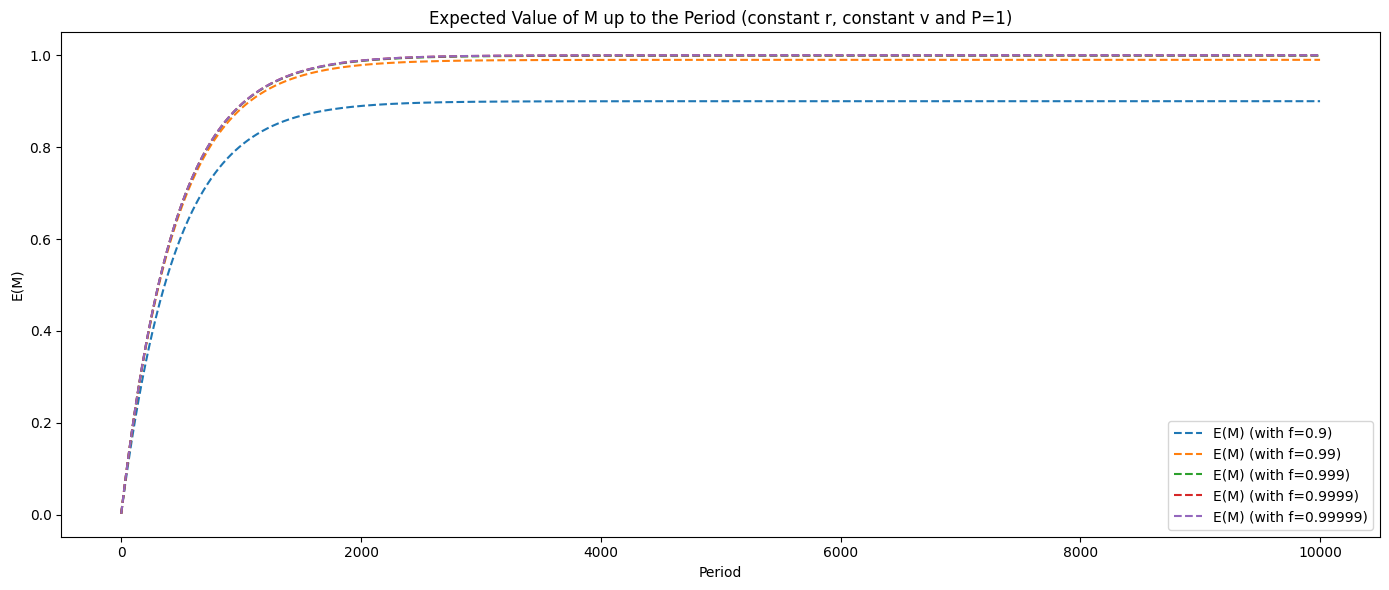

Final E(M) values for each f: [0.8999999998177373, 0.9899999997959412, 0.9989999997977748, 0.9998999997966393, 0.9999899997953889]
Ratio of E(M) to E(w) for f=0.9: 0.002010534305819143
Ratio of E(M) to E(w) for f=0.99: 0.0022115877363930825
Ratio of E(M) to E(w) for f=0.999: 0.0022316930794594415
Ratio of E(M) to E(w) for f=0.9999: 0.0022337036137631315
Ratio of E(M) to E(w) for f=0.99999: 0.002233904667190961


In [37]:
plot_expected_value_of_M_up_to_t_different_fs(10000, fs=[0.9, 0.99, 0.999, 0.9999, 0.99999], r_type="constant", v_type="constant", P=1, hide_benchmark=True)

In terms of the interpretation, in the constant risk and value scenario. If persistence is of one year $P = 1$, even an action that essentially totally erradicates risk, is worth one year of value, as would be intuitively expected.

## Grid: Scenarios of E(M)

First, based on ```plot_mitigated_vs_unmitigated_Ew_convergence```, we define a new function that plots the convergence of $E(M)$ for different values of $P$ and can be used in our grid.

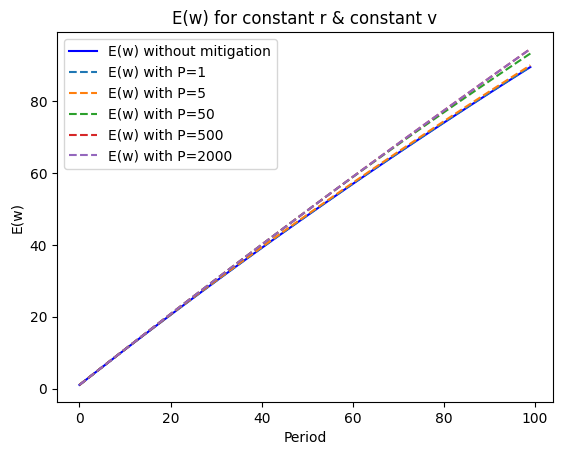

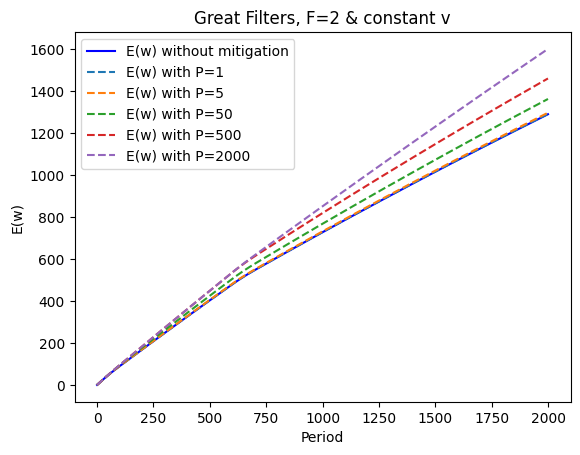

In [41]:
def middle_plot_mitigated_vs_unmitigated_Em_convergence(T, f=0.5, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant", tolerance=1e-5, eras_periods=[100, 500, 100, T - 700], eras_risks=[0.0022289477, 0.0001, 0.0022289477, 0.0001], axes=None):
    if axes is None:
        fig, axes = plt.subplots()

    # Initialize variables
    Ew_original = 0
    prod_term_original = 1
    Ew_list_original = []
    prev_Ew_original = None

    Ew_mitigated = {P: 0 for P in Ps}
    prod_term_mitigated = {P: 1 for P in Ps}
    Ew_list_mitigated = {P: [] for P in Ps}
    prev_Ew_mitigated = {P: None for P in Ps}

    converged_flags = {P: False for P in Ps} # Flags to indicate if E(w) has converged for each P

    # Generate the constant value and risk vectors
    v = generate_value_vector(T+1, v_type=v_type)
    r_original = generate_risk_vector(T+1,r_type=r_type, eras_periods=eras_periods, eras_risks=eras_risks)

    for t in range(1, T + 1):
        # Update original E(w) values
        Ew_original, prod_term_original = calculate_Ew_incremental(Ew_original, prod_term_original, v[t-1:t], r_original[t-1:t])

        # Update mitigated E(w) values for each P
        for P in Ps:
            r_mitigated = apply_mitigation(r_original, 0.5, P)
            Ew_mitigated[P], prod_term_mitigated[P] = calculate_Ew_incremental(Ew_mitigated[P], prod_term_mitigated[P], v[t-1:t], r_mitigated[t-1:t])

        # Store and check the E(w)
        Ew_list_original.append(Ew_original)

        for P in Ps:
            Ew_list_mitigated[P].append(Ew_mitigated[P])

            if prev_Ew_mitigated[P] is not None and not converged_flags[P]:
                if has_converged(Ew_mitigated[P], prev_Ew_mitigated[P], tolerance):
                    print(f"{r_type} r and {v_type} v converged at period {t}, E(w) with P={P} is {Ew_mitigated[P]:.6f}")
                    converged_flags[P] = True

        prev_Ew_original = Ew_original
        for P in Ps:
            prev_Ew_mitigated[P] = Ew_mitigated[P]

   # Plot
    axes.plot(Ew_list_original, label="E(w) without mitigation", color='b')
    
    for P in Ps:
        axes.plot(Ew_list_mitigated[P], linestyle="--", label=f"E(w) with P={P}")

    axes.set_title(f"E(w) for {r_type} r & {v_type} v")
    if r_type == "eras":
        # axes.axvspan(eras_periods[0], eras_periods[1], color='red', alpha=0.5)
        # axes.axvspan(eras_periods[3], eras_periods[3], color='blue', alpha=0.5)
        axes.set_title(f"Great Filters, F={int(len(eras_periods)/2)} & {v_type} v")
    axes.set_xlabel("Period")
    axes.set_ylabel("E(w)")
    axes.legend()




    
# Test usage
T=100
middle_plot_mitigated_vs_unmitigated_Em_convergence(T, f=0.5, r_type="constant", v_type="constant")
plt.show()

# and under eras
T=2000
middle_plot_mitigated_vs_unmitigated_Em_convergence(T, f=0.5, r_type="eras", v_type="constant")
plt.show()


We are now ready to evaluate $E(M)$ under the different cases for both risk and value. We display these various scenarios in a grid. For efficiency, we will specify manual Ts for each middle subplot.

In [44]:
def plot_grid_Em_manual(Ts=[1000], tolerance=1e-5, Ps=[1, 5, 50, 500, T]):
    # Have the option to set different values of T for each sub-plot
    # Ts is a list of T values for each sub-plot, in the order of the middle sub-plots in the grid
    # If Ts is shorter than the number of sub-plots, the last T value will be used for the remaining sub-plots
    
    Ts = Ts + [Ts[-1]] * (20 - len(Ts)) # Pad Ts with the last value if the list is shorter than 20
    T = Ts[0] # We'll use this T value for the first row and column
    
    # Eras parameters
    eras_periods_here=[100, 500, 100, T - 700]
    eras_risks_here=[0.0022289477, 0.0001, 0.0022289477, 0.0001]

    # Initialize values, types, Ps and colors
    value_types = ["constant", "linear", "quadratic", "cubic", "logistic"]
    r_types = ["constant", "top", "eras", "exponential_decay"]
    Ps = Ps  # We'll calculate E(M) for each of these values of P

    colors_value = ["b", "g", "r", "c", "m"]
    colors_risk = ["b", "g", "r", "m"]

    fig, all_axes = plt.subplots(5, 6, figsize=(30, 25))
    
    # Turn off the axis for the top-left subplot.
    all_axes[0, 0].axis('off')

    # First row: different value vectors
    for i, v_type in enumerate(value_types):
        axes = all_axes[0, i + 1]
        v = generate_value_vector(T, v_type)
        axes.plot(v, color=colors_value[i])
        axes.set_title(f"{v_type} value")
        axes.set_xlabel("years")
        axes.set_ylabel("value")

    # First column: different risk vectors
    for i, r_type in enumerate(r_types):
        axes = all_axes[i + 1, 0]
        r = generate_risk_vector(T, r_type, eras_periods=eras_periods_here, eras_risks=eras_risks_here)
        axes.plot(r, color=colors_risk[i]) # previously: plt.plot(range(1, T + 1), r, color=colors_risk[i]) for plotting against period earlier (shifted by 1)
        if r_type == "eras":
            axes.set_title(f"Great Filters, F={int(len(eras_periods_here)/2)}")
        else:
            axes.set_title(f"{r_type} risk")
        axes.set_xlabel("years")
        axes.set_ylabel("risk")

    # Middle plots: E(M) for each combination of value and risk
    for i, v_type in enumerate(value_types):
        for j, r_type in enumerate(r_types):
            
            # For the middle sub-plots, we'll use the T value from the Ts list
            T = Ts[j + 4 * i]
            
            # Update Ps and eras_periods_here according to the new T
            Ps = Ps
            eras_periods_here=[100, 500, 100, T - 700]
            
            # For debugging print(f"Plotting {v_type} v and {r_type} r for T={T}")
            axes = all_axes[j + 1, i + 1]
            middle_plot_mitigated_vs_unmitigated_Em_convergence(T, Ps=Ps, r_type=r_type, v_type=v_type, tolerance=tolerance, eras_periods=eras_periods_here, eras_risks=eras_risks_here, axes=axes)
            
    plt.tight_layout()
    plt.show()

In [45]:
# For internal experiments only
# skip this cell in general
# if not skip_execution:
def properties_Ts(Ts):
    length = len(Ts)
    print("Length of the list:", length)
    print("Total periods evaluated:", sum(Ts))
    
    print("\nTable of periods used in each case:")
    row_labels = ['Constant r', 'ToP r', '2 Great Filters', 'Decaying r']
    col_labels = ['Constant v', 'Linear v', 'Quadratic v', 'Cubic v', 'Logistic v']
    rows, cols = 4, 5
    array = [["" for _ in range(cols + 1)] for _ in range(rows + 1)]

    array[0][1:] = col_labels
    for r in range(1, rows + 1):
        array[r][0] = row_labels[r - 1]

    for r in range(1, rows + 1):
        for c in range(1, cols + 1):
            index = (c - 1) * rows + (r - 1)
            if index < length:
                array[r][c] = str(Ts[index])

    col_widths = [max(len(str(value)) for value in column) for column in zip(*array)]

    for row in array:
        for value, width in zip(row, col_widths):
            print(f"{value:<{width}}", end="  ")
        print()


In [46]:
# generate list of Ts from 100 onwards, increasing by a factor of 100 each time≥, 20 times
Ts_eg = [1000 +100 * i for i in range(20)] # 1000, 1100, 1200, ..., 2900, 3000     This takes about 11 seconds to run

properties_Ts(Ts_eg)

Length of the list: 20
Total periods evaluated: 39000

Table of periods used in each case:
                 Constant v  Linear v  Quadratic v  Cubic v  Logistic v  
Constant r       1000        1400      1800         2200     2600        
ToP r            1100        1500      1900         2300     2700        
2 Great Filters  1200        1600      2000         2400     2800        
Decaying r       1300        1700      2100         2500     2900        


In [49]:
# plot_grid_Em_manual(Ts=Ts_eg) # This takes about 10s to run

Length of Ts_experiment: 20
Total periods considered in Ts_experiment: 1130000
constant r and quadratic v converged at period 9225, E(w) with P=1 is 22440.409251
constant r and quadratic v converged at period 9227, E(w) with P=5 is 22540.826468
constant r and quadratic v converged at period 9252, E(w) with P=50 is 23700.257389
constant r and quadratic v converged at period 9501, E(w) with P=500 is 38147.392676


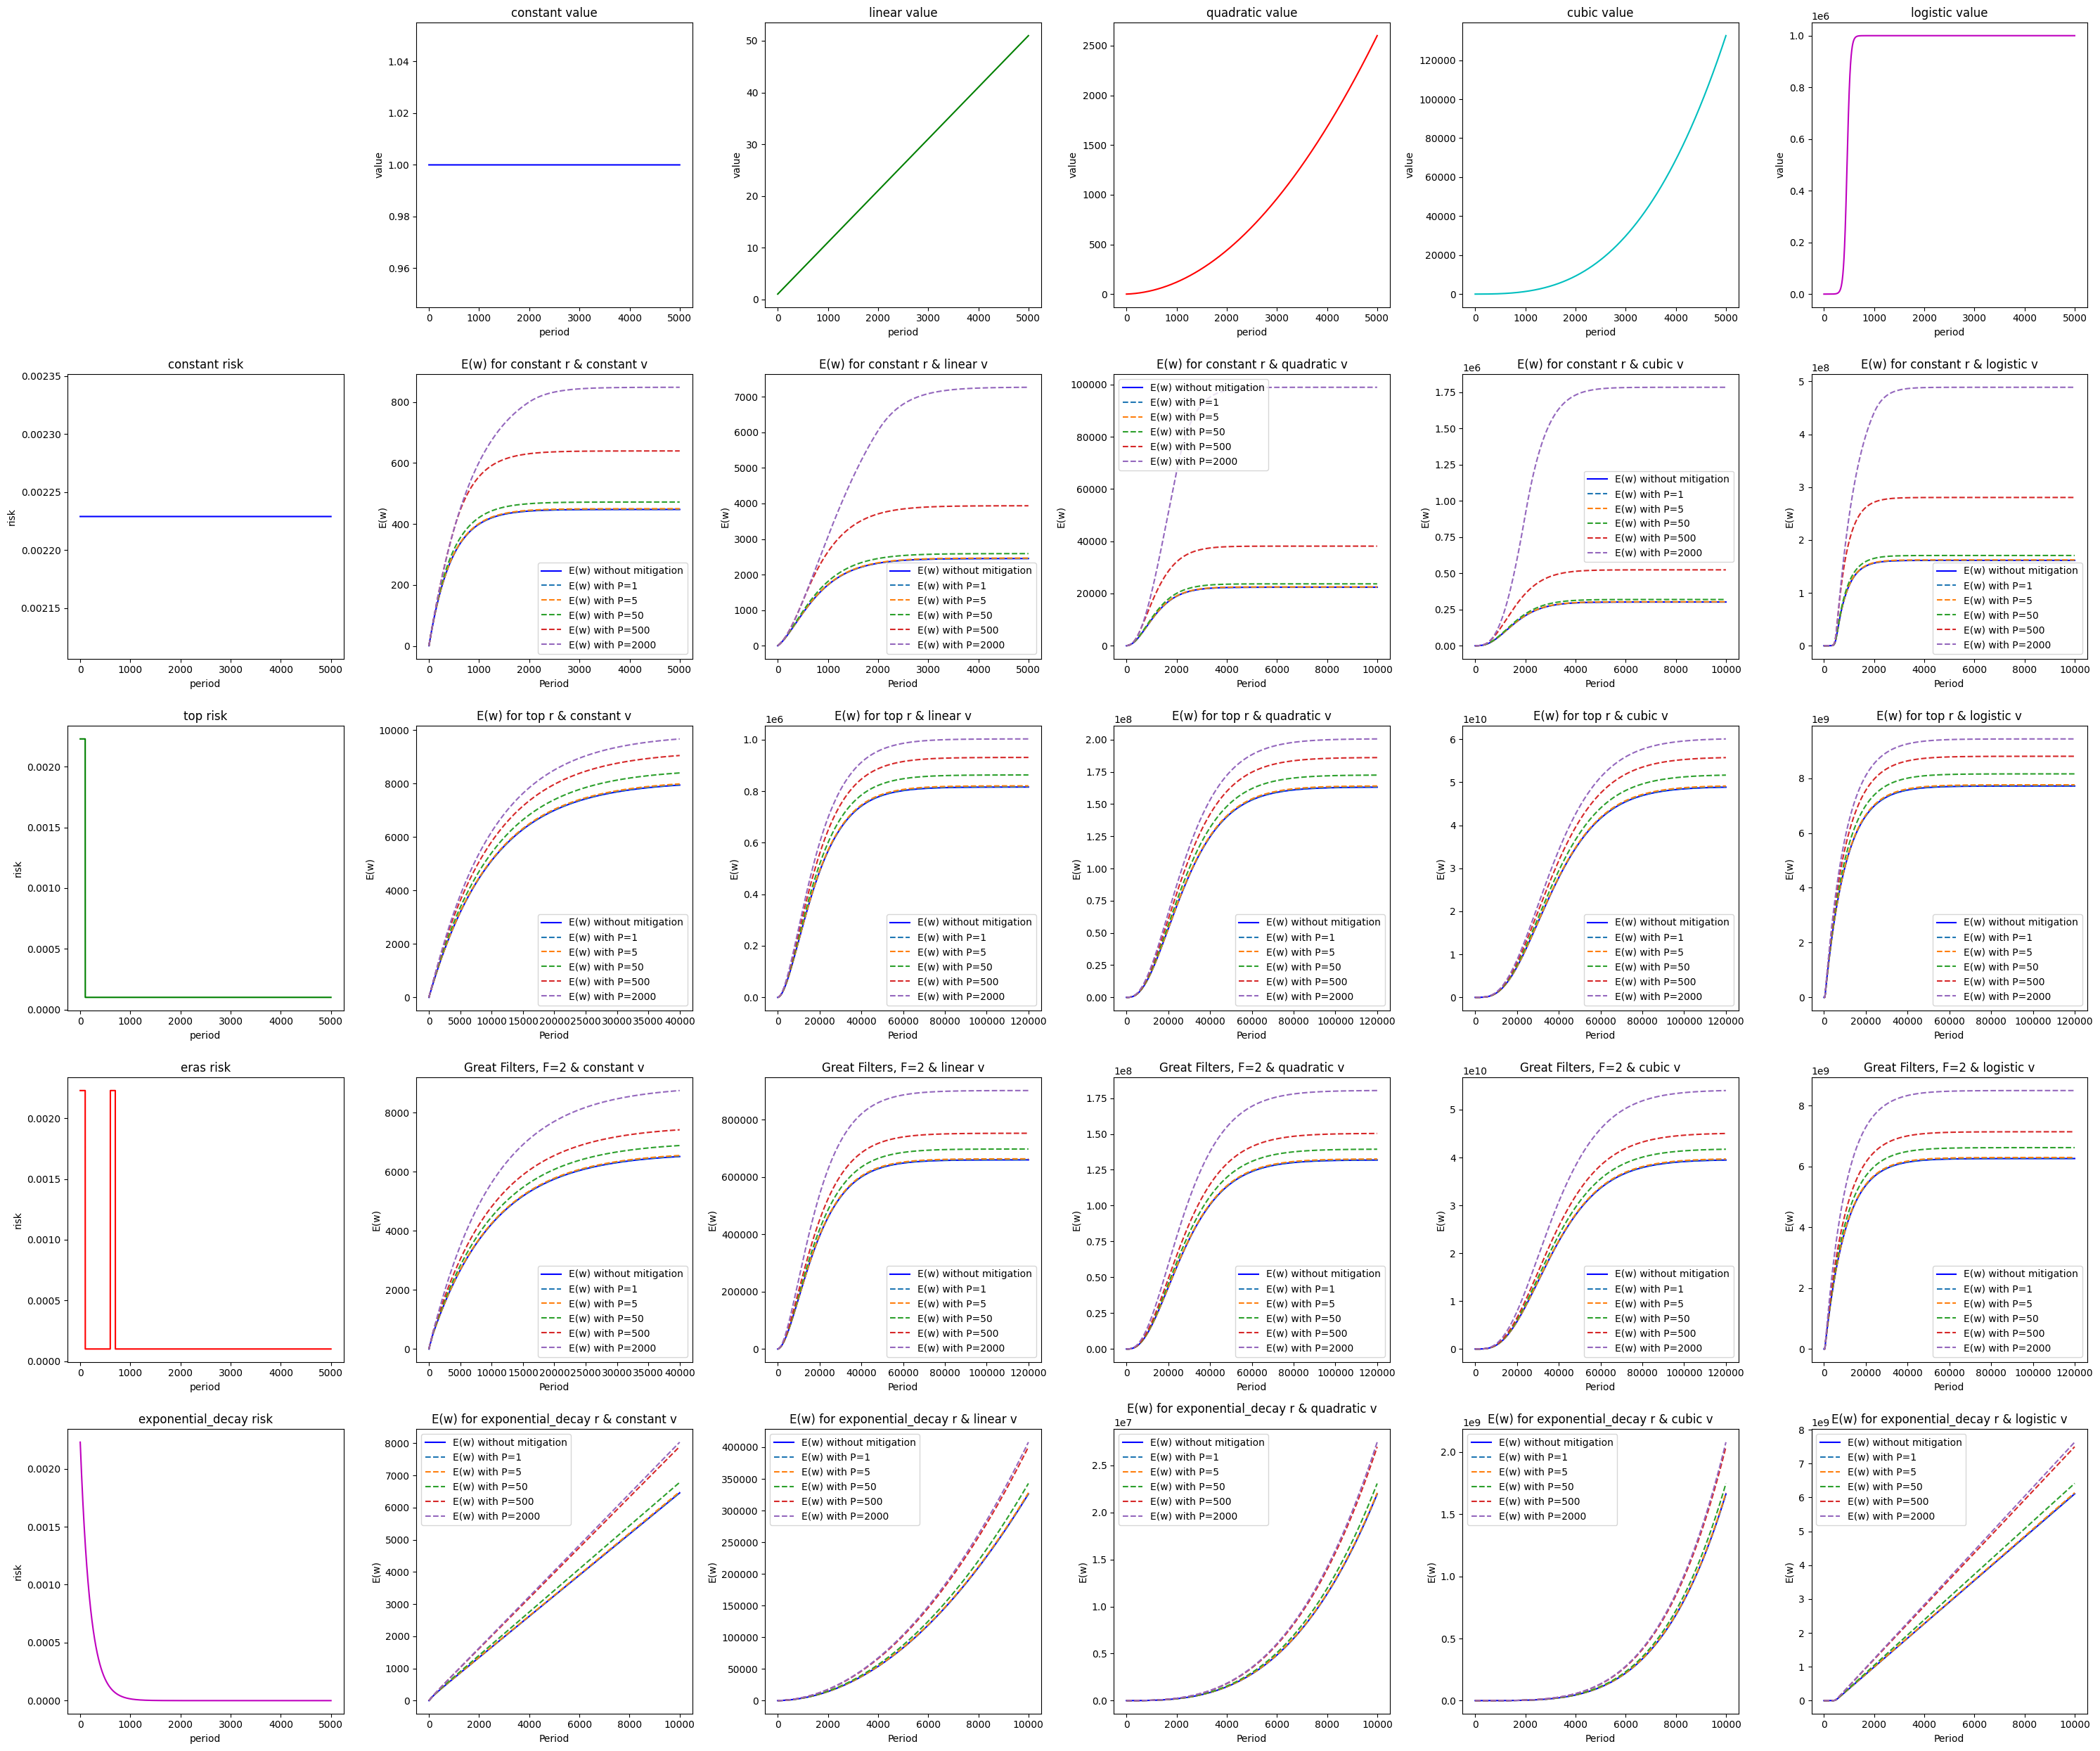

In [48]:
Ts_experiment = [5000, 40000, 40000, 10000, 5000, 120000, 120000, 10000, 10000, 120000, 120000, 10000, 10000, 120000, 120000, 10000, 10000, 120000, 120000, 10000]

# total periods considered in Ts_experiment is sum of elements in Ts_experiment
# print(f"Total periods considered in Ts_experiment: {sum(Ts_experiment)}") # 1,130,000

plot_grid_Em_manual(Ts=Ts_experiment)

# # Experiment with other Ps
# plot_grid_Em_manual(Ts=Ts_experiment, Ps=[1, 50, 500, 10000])


# for some reason largest P was older one we passed of 2000, not 10000, this took 45m to run

Some headline results from the grid:
- The value of $M$ is, in expectation, consistently of the same magnitude as $E(w)$ for all $f\leq0.5$. [confirm]
- The value of $M$ (and of $E(w)$) explodes if the risk decays exponentially.
    - As a corollary, an alternative version of ToP that had expontentially decaying risk after the high risk period would behave similarly.

P makes a big difference in pretty much all the cases, think about why in exp decay difference between 50 and 500 is much bigger than 500 and 2000

Emphasise scale (e^7) orders of magnitude difference depending on growth paths

Do comparison between base case within each row, how many orders of magnitude moving to a graph to the right buy. eg TOP  5 to 8 to 12 to 16 to 12

fixing col: those comparisons are within one order of magnitude difference, in a sense ToP isn't buying that much more value in constant [contrast to T?], the impact of how many orders of magnitude Top buys you depends on assumptions about growth. 4 orders of m in cubic

Adding another filter keeps you in the same order of magnitude, only reduces you by 20%

Discussion: one graph to another

fix y axis if pulling out for discussion

could show constant as good pedagogical example

quadratic as more realistic alternative

given these values
Risk: constant vs top
Risk: different filters

Risk Exp decay to top

5 to 50 are most interesting persistences
5 feels particularly realistic

pick and choose your one...

stretch exponential (Economically relevant?)

Intuition: The more valueable we expect the world to be, the more it is worth saving it. There are no departures from that intuition.

Organise these int 'lessons' wo explicitly saying lessons with bold titles.

Do a table/grid but for E(M)

Lastly, for these grids, let us try with a very large persistence of $P=100,000$. This time, we will ommit the other $P$ values. After experimenting, we try with custom Ts for each subplot that let us observe convergence.

In [68]:
Ts_largeP = [5000, 50000, 50000, 10000, 6000, 90000, 90000, 10000, 7000, 120000, 120000, 10000, 10000, 130000, 130000, 10000, 7000, 70000, 70000, 10000]

properties_Ts(Ts_largeP)

Length of the list: 20
Total periods evaluated: 1005000

Table of periods use in each case:
                 Constant v  Linear v  Quadratic v  Cubic v  Logistic v  
Constant r       5000        6000      7000         10000    7000        
ToP r            50000       90000     120000       130000   70000       
2 Great Filters  50000       90000     120000       130000   70000       
Decaying r       10000       10000     10000        10000    10000       


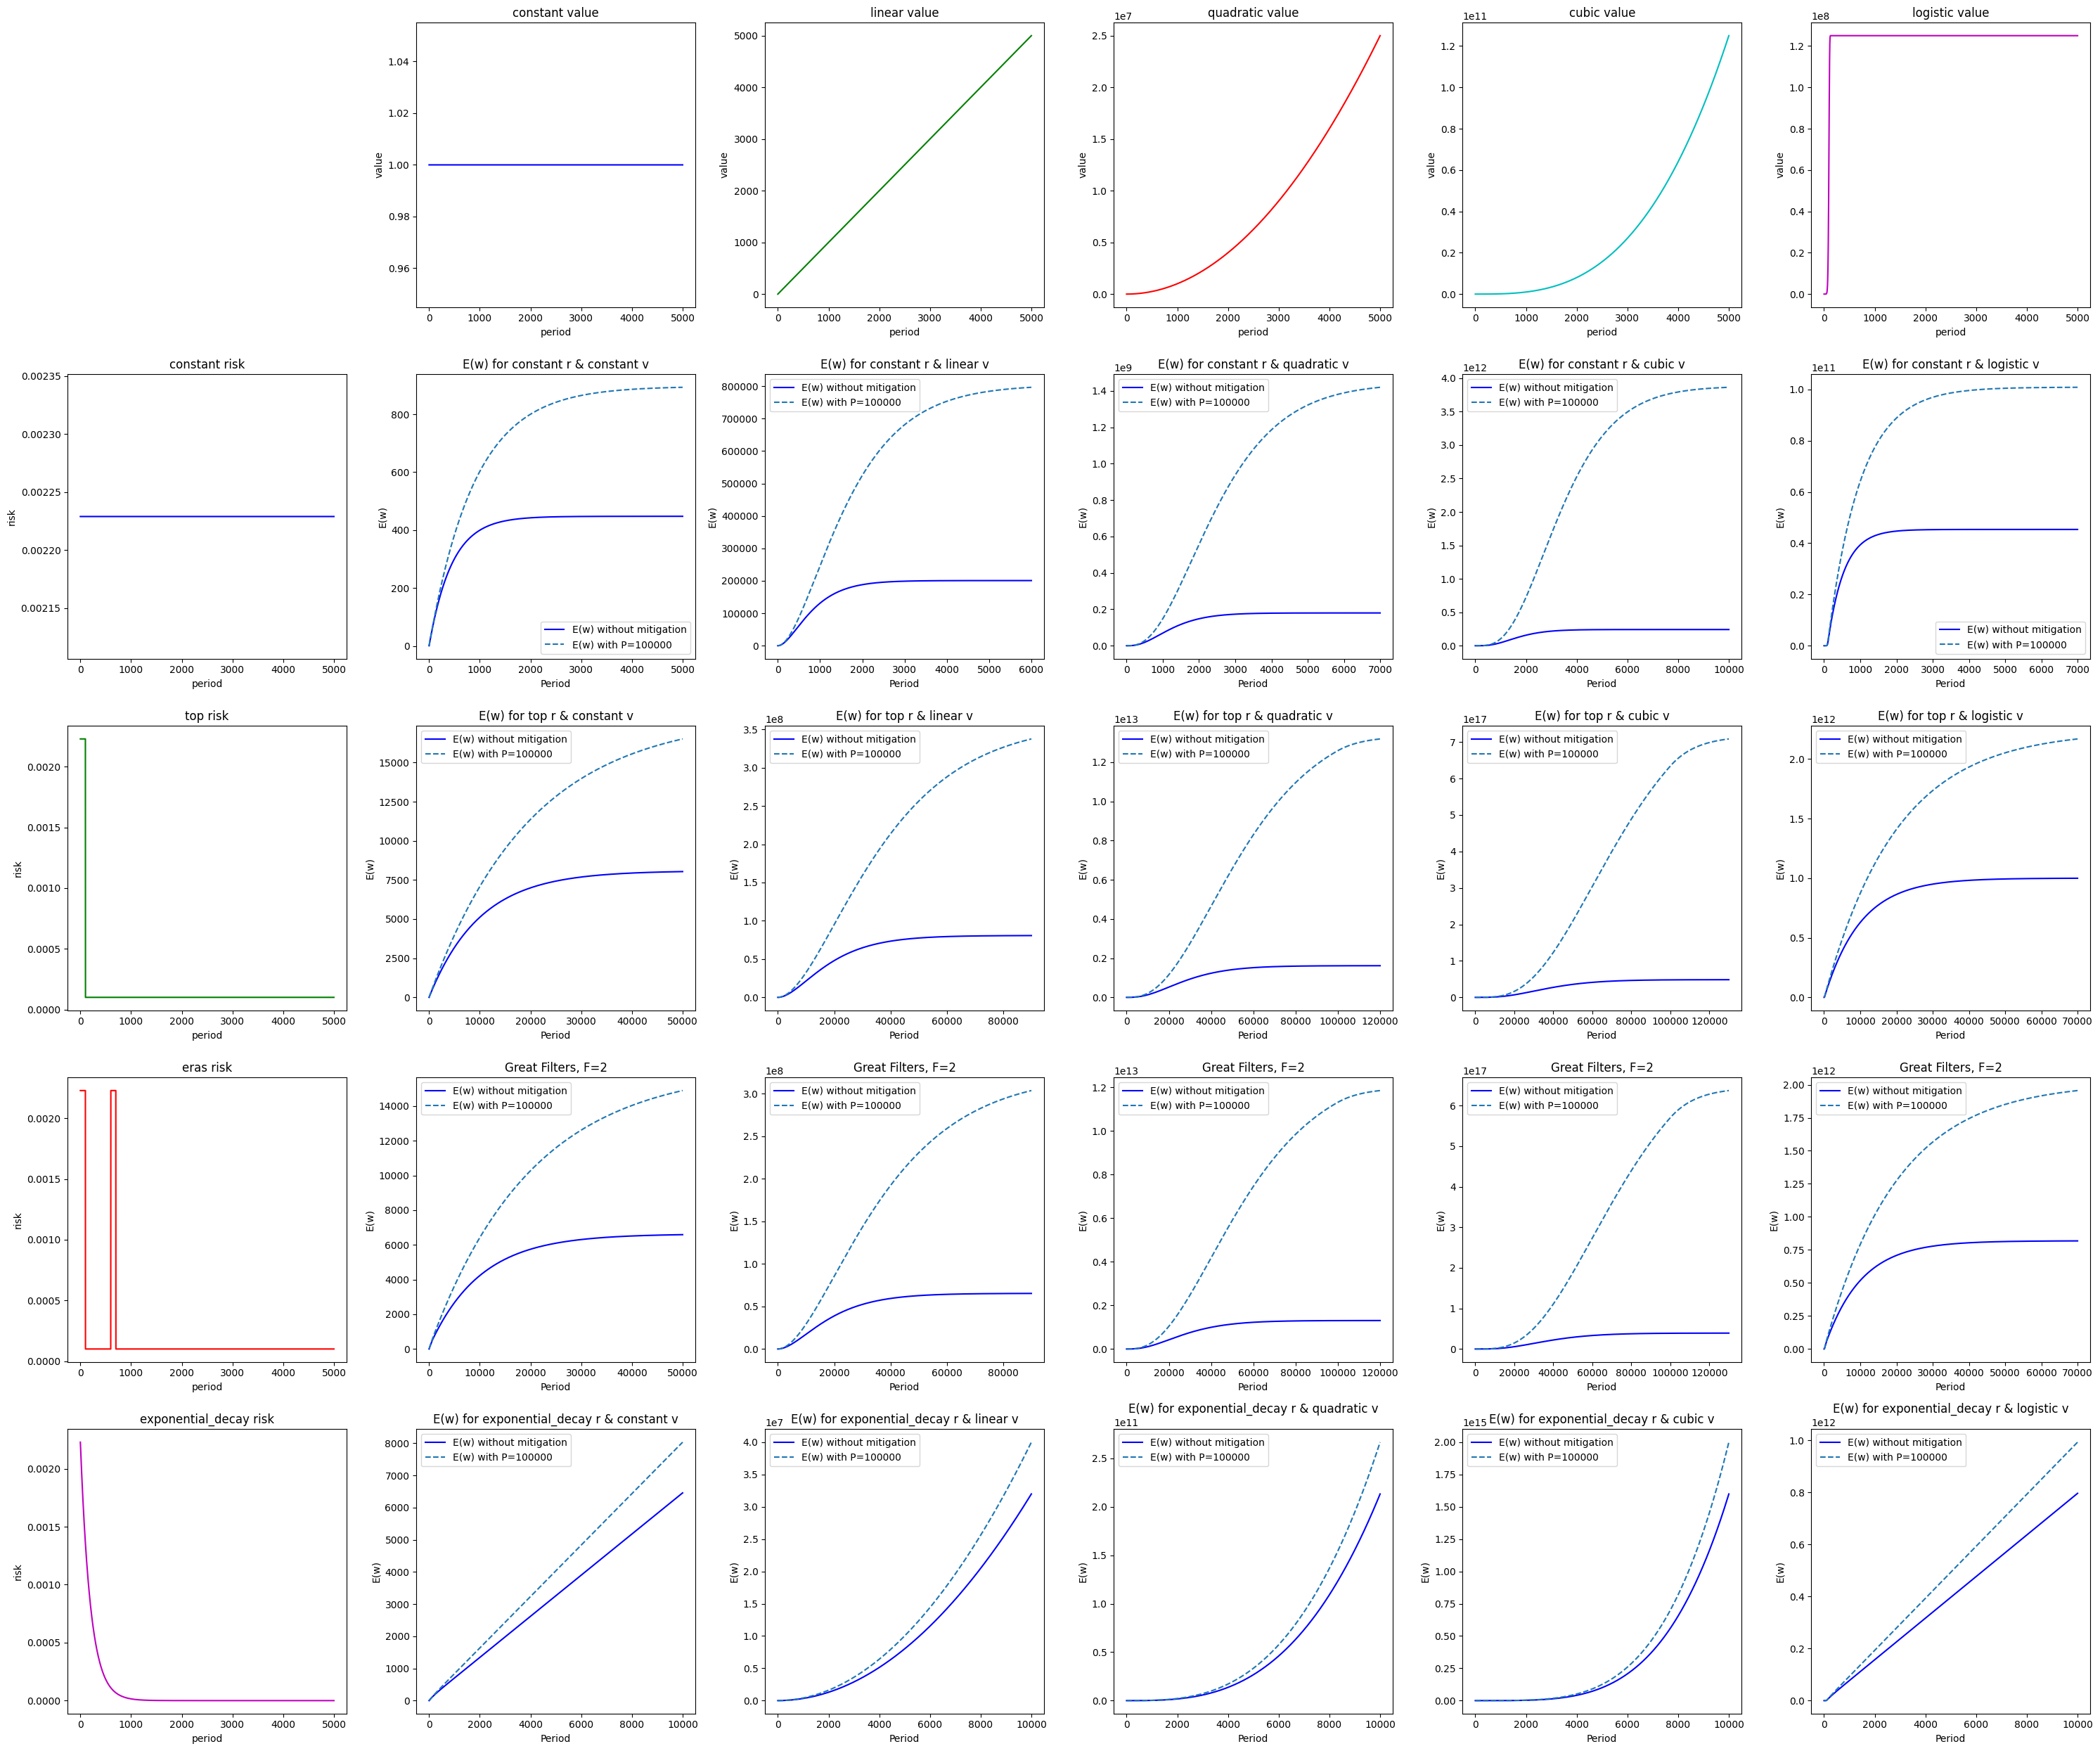

In [70]:
Ps_large = [100000]

# plot_grid_Em_manual(Ts=Ts_largeP, Ps=Ps_large) # 1h 32m to run

# Display the saved plot image
display(Image(filename='E(M) large P.png'))

In [ ]:
# %%skip
# # This cell will be skipped during execution
# print("This won't be executed")


UsageError: Cell magic `%%skip` not found.


To do in the future: It would be interesting to do a grid where we vary the number of filters. 1,2 we already have, it'd be good to see 3 and 5.

# Appendix

## Quick Check, script based on the concrete example from report

In [155]:
# Write a script that evaluates the following equation \left( \sum ^{100}_{i=1} \left( 1-0.002229\right)^i + \left( 1-0.002229\right)^{100}\sum ^{9900}_{i=1}\left( 1-0.0001\right)^i  \right)

def evaluate_equation(r1,r2):
    sum1 = 0
    for i in range(1, 101):
        sum1 += (1 - r1) ** i
    sum2 = 0
    for i in range(1, 9901):
        sum2 += (1 - r2) ** i
    result = sum1 + (1 - r1) ** 100 * sum2
    return result



# Write a script that evaluates the following equation \sum ^{5}_{i=1} \beta ^i + \beta ^{5} \sum ^{95}_{i=1} \left( 1-0.002229\right)^i + \beta ^{5}\left( 1-0.002229\right)^{95}\sum ^{9900}_{i=1}\left( 1-0.0001\right)^i

def evaluate_equation_M(r1,r2):
    sum1 = 0
    beta=(1-r1/2)
    for i in range(1, 6):
        sum1 += beta ** i
    sum2 = 0
    for i in range(1, 96):
        sum2 += (1 - r1) ** i
    sum3 = 0
    for i in range(1, 9901):
        sum3 += (1 - r2) ** i
    result = sum1 + beta ** 5 * sum2 + beta ** 5 * (1 - r1) ** 95 * sum3
    return result

In [163]:
def example_check():
    general = expected_value_vector_of_M_up_to_t(10000, r_type="eras", v_type="constant",f = 0.5, P = 5, eras_periods = [100, 10000 - 100], eras_risks = [0.002229, 0.0001])[-1]
    
    eval = evaluate_equation(0.002229, 0.0001)
    evalm = evaluate_equation_M(0.002229, 0.0001)
    direct = evalm - eval
    
    # Print the example with and without M
    print(f"When calculated directly E(w) = ",eval)
    print(f"When calculated directly E(w') = ",evalm)
    print(f"When calculated directly E(M) = ",direct)
    print("\n")
    
    # With our general method
    print(f"When calculated generally, E(M) = ",general)
    print("\n")

    
    # print difference equation of the two approaches
    print(f"The difference between in previous estimate is:" , general - direct)
    
 example_check() # tiny difference: 0.0000000000000004440892098500627

When calculated directly E(w) =  5116.53273619555
When calculated directly E(w') =  5145.161060930257
When calculated directly E(M) =  28.62832473470735


When calculated generally, E(M) =  28.628324734711896


The difference between in previous estimate is: 4.547473508864641e-12


## Example constant value, persistence 5

In [2]:
def general_method(T, v_c, r_first_100, r_after_100):
    sum_r = 0
    product_r = 1
    for i in range(1, T + 1):
        sum_r += product_r * v_c
        if i <= 100:
            product_r *= (1 - r_first_100)
        else:
            product_r *= (1 - r_after_100)
    return sum_r

def geometric_series_method(T, v_c, r_first_100, r_after_100):
    # First 100 years geometric series
    S_100 = (1 / (1 - (1 - r_first_100))) * (1 - (1 - r_first_100)**100)
    
    # After 100 years geometric series
    S_10000 = ((1 - r_first_100)**100 / (1 - (1 - r_after_100))) * (1 - (1 - r_after_100)**(T-100))
    
    return v_c * (S_100 + S_10000)

T = 10000
v_c = 1
r_first_100 = 0.00222894771
r_after_100 = 0.0001

print("General method:", general_method(T, v_c, r_first_100, r_after_100))
print("Geometric series method:", geometric_series_method(T, v_c, r_first_100, r_after_100))

General method: 5117.262062779533
Geometric series method: 5117.262062779516


In [50]:
# def expected_value_general(T, v_c, r_sequence):
#     sum_r = 0
#     product_r = 1
#     for i in range(1, T + 1):
#         sum_r += product_r * v_c
#         product_r *= (1 - r_sequence[i - 1])
#     return sum_r

def expected_value_geometric(T, v_c, r_first_segment, r_second_segment, r_rest):
    len_first = len(r_first_segment)
    len_second = len(r_second_segment)
    # First segment
    S_first = (1 / (1 - (1 - r_first_segment[-1]))) * (1 - (1 - r_first_segment[-1])**len_first)
    
    # Second segment
    S_second = ((1 - r_first_segment[-1])**len_first / (1 - (1 - r_second_segment[-1]))) * (1 - (1 - r_second_segment[-1])**len_second)
    
    # Rest of the time
    S_rest = ((1 - r_second_segment[-1])**len_second * (1 - r_first_segment[-1])**len_first / (1 - (1 - r_rest))) * (1 - (1 - r_rest)**(T - len_first - len_second))
    
    return v_c * (S_first + S_second + S_rest)


def expected_value_general(T, v_c, r_first_segment, r_second_segment, r_rest):
    sum_r = 0
    product_r = 1
    
    # First segment
    for i in range(len(r_first_segment)):
        product_r *= (1 - r_first_segment[i])
        sum_r += product_r * v_c
    
    # Second segment (only if it's not empty)
    if r_second_segment:
        for i in range(len(r_second_segment)):
            product_r *= (1 - r_second_segment[i])
            sum_r += product_r * v_c
    
    # Rest of the time
    for i in range(T - len(r_first_segment) - len(r_second_segment)):
        product_r *= (1 - r_rest)
        sum_r += product_r * v_c
    
    return sum_r

T = 10000
v_c = 1

# Risks for E(w)
r_w_first = [0.00222894771] * 100
r_w_second = []
r_w_rest = 0.0001

# Risks for E(w')
r_w_prime_first = [0.0011145] * 5
r_w_prime_second = [0.00222894771] * 95
r_w_prime_rest = 0.0001

# Calculate E(w) and E(w') using both methods
E_w_general = expected_value_general(T, v_c, r_w_first, r_w_second, r_w_rest)
E_w_prime_general = expected_value_general(T, v_c, r_w_prime_first, r_w_prime_second, r_w_prime_rest)

E_w_geometric = expected_value_geometric(T, v_c, r_w_first, r_w_second, r_w_rest)
E_w_prime_geometric = expected_value_geometric(T, v_c, r_w_prime_first, r_w_prime_second, r_w_prime_rest)

# Print the results
print("E(w) using general method:", E_w_general)
print("E(w') using general method:", E_w_prime_general)
print("Difference (general method):", E_w_prime_general - E_w_general)

print("\nE(w) using geometric series method:", E_w_geometric)
print("E(w') using geometric series method:", E_w_prime_geometric)
print("Difference (geometric series method):", E_w_prime_geometric - E_w_geometric)



T = 10000
v_c = 1

# Risks for E(w)
r_w = [0.00222894771]*100 + [0.0001]*(T-100)

# Risks for E(w')
r_w_prime = [0.0011145]*5 + [0.00222894771]*95 + [0.0001]*(T-100)

# Calculate E(w) and E(w') using both methods
E_w_general = expected_value_general(T, v_c, r_w)
E_w_prime_general = expected_value_general(T, v_c, r_w_prime)

# E_w_geometric = expected_value_geometric(T, v_c, 0.00222894771, 0.00222894771, 0.0001)
# E_w_prime_geometric = expected_value_geometric(T, v_c, 0.0011145, 0.00222894771, 0.0001)

# Print the results
print("E(w) using general method:", E_w_general)
print("E(w') using general method:", E_w_prime_general)
print("Difference (general method):", E_w_prime_general - E_w_general)

print("\nE(w) using geometric series method:", E_w_geometric)
print("E(w') using geometric series method:", E_w_prime_geometric)
print("Difference (geometric series method):", E_w_prime_geometric - E_w_geometric)


IndexError: list index out of range

## Table of $E(M)$ for different values and $P$

In [62]:
# A function just like middle_plot_mitigated_vs_unmitigated_Em_convergence but that outputs the final E(M) values for each scenario and for all values of P, instead of plotting them

def calculate_final_Em(T, f=0.5, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant", tolerance=1e-5, eras_periods=[100, 500, 100, T - 700], eras_risks=[0.0022289477, 0.0001, 0.0022289477, 0.0001]):
    # Initialize variables
    Ew_original = 0
    prod_term_original = 1
    Ew_list_original = []
    prev_Ew_original = None

    Ew_mitigated = {P: 0 for P in Ps}
    Em = {P: 0 for P in Ps}
    prod_term_mitigated = {P: 1 for P in Ps}
    Ew_list_mitigated = {P: [] for P in Ps}
    prev_Ew_mitigated = {P: None for P in Ps}

    converged_flags = {P: False for P in Ps} # Flags to indicate if E(w) has converged for each P

    # Generate the constant value and risk vectors
    v = generate_value_vector(T+1, v_type=v_type)
    r_original = generate_risk_vector(T+1,r_type=r_type, eras_periods=eras_periods, eras_risks=eras_risks)

    for t in range(1, T + 1):
        # Update original E(w) values
        Ew_original, prod_term_original = calculate_Ew_incremental(Ew_original, prod_term_original, v[t-1:t], r_original[t-1:t])

        # Update mitigated E(w) values for each P
        for P in Ps:
            r_mitigated = apply_mitigation(r_original, 0.5, P)
            Ew_mitigated[P], prod_term_mitigated[P] = calculate_Ew_incremental(Ew_mitigated[P], prod_term_mitigated[P], v[t-1:t], r_mitigated[t-1:t])

        # Store and check the E(w)
        Ew_list_original.append(Ew_original)

        for P in Ps:
            Ew_list_mitigated[P].append(Ew_mitigated[P])

            if prev_Ew_mitigated[P] is not None and not converged_flags[P]:
                if has_converged(Ew_mitigated[P], prev_Ew_mitigated[P], tolerance):
                    print(f"{r_type} r and {v_type} v converged at period {t}, E(w) with P={P} is {Ew_mitigated[P]:.6f}")
                    converged_flags[P] = True

        prev_Ew_original = Ew_original
        for P in Ps:
            prev_Ew_mitigated[P] = Ew_mitigated[P]
            
    # calculate E(M) for each P
    for P in Ps:
        Em[P] =  Ew_list_mitigated[P][-1] -Ew_list_original[-1]
    
    # Return the final E(M) values for each P
    return Em

In [63]:
# Example usage
T=1000
calculate_final_Em(T, f=0.5, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant")

{1: 0.446312908169773,
 5: 2.2253980429970284,
 50: 21.570255296526852,
 500: 155.8170871523144,
 1000: 202.83008578322648}

This example is interesting, quintupling persistence increases value by 4. a 500 fold increase (1 vs 50) only by 40 times and $P= 1$ to $P=500$ is 300 times more value.

In [80]:
# Let us create a function that works exactly like plot_grid_Em_manual but it outputs the final E(M) values for each scenario and for all values of P, instead of plotting them

def calculate_final_Ems(Ts=[1000], tolerance=1e-5, Ps=[1, 5, 50, 500, T]):
    Ts = Ts + [Ts[-1]] * (20 - len(Ts)) # Pad Ts with the last value if the list is shorter than 20
    # T = Ts[0] # We'll use this T value for the first row and column
    
    # # Eras parameters
    # eras_periods_here=[100, 500, 100, T - 700]
    eras_risks_here=[0.0022289477, 0.0001, 0.0022289477, 0.0001]

    # Initialize values, types, Ps and colors
    value_types = ["constant", "linear", "quadratic", "cubic", "logistic"]
    r_types = ["constant", "top", "eras", "exponential_decay"]
    Ps = Ps  # We'll calculate E(M) for each of these values of P
    
    # Create a dictionary to store the final E(M) values for each scenario and for all values of P
    final_Ems = {v_type: {r_type: {P: None for P in Ps} for r_type in ["constant", "top", "eras", "exponential_decay"]} for v_type in ["constant", "linear", "quadratic", "cubic", "logistic"]}
    # print(final_Ems)
    
     
    for i, v_type in enumerate(value_types):
        for j, r_type in enumerate(r_types):
        
            # For the middle sub-plots, we'll use the T value from the Ts list
            T = Ts[j + 4 * i]
            
            # Update Ps and eras_periods_here according to the new T
            Ps = Ps
            eras_periods_here=[100, 500, 100, T - 700]
            
            # Add the final E(M) values for each P to the dictionary
            final_Ems[v_type][r_type] = calculate_final_Em(T, f=0.5, Ps=Ps, r_type=r_type, v_type=v_type, tolerance=tolerance, eras_periods=eras_periods_here, eras_risks=eras_risks_here)
                
    return final_Ems

# Use it to calculate the final E(M) values for each scenario and for all values of P, as we saw in the grid
Ts_experiment = [5000, 40000, 40000, 10000, 5000, 120000, 120000, 10000, 10000, 120000, 120000, 10000, 10000, 120000, 120000, 10000, 10000, 120000, 120000, 10000]
# T=1e5 # later this is used for the grid with large P
T=2000
calculate_final_Ems(Ts=Ts_experiment, tolerance=1e-5, Ps=[1, 5, 50, 500, T]) 
# as expected runtime is independednt of the T value in Ps
# T=2000 and Ts_experiment had a runtime of 46m 41s

constant r and quadratic v converged at period 9225, E(w) with P=1 is 22440.409251
constant r and quadratic v converged at period 9227, E(w) with P=5 is 22540.826468
constant r and quadratic v converged at period 9252, E(w) with P=50 is 23700.257389
constant r and quadratic v converged at period 9501, E(w) with P=500 is 38147.392676


{'constant': {'constant': {1: 0.49999286376043983,
   5: 2.494398076559264,
   50: 24.329032349106228,
   500: 191.7397069868697,
   2000: 400.3564192603603},
  'top': {1: 8.869555926429712,
   5: 44.43580283172105,
   50: 454.46646936148045,
   500: 1106.0869955407898,
   2000: 1726.4805491180205},
  'eras': {1: 7.277569603204029,
   5: 36.458069437104314,
   50: 372.6494244735168,
   500: 905.5607446114636,
   2000: 2233.503028404548},
  'exponential_decay': {1: 7.2139004280379595,
   5: 35.77878683349354,
   50: 326.58921011474376,
   500: 1441.0196861512559,
   2000: 1576.1887545004847}},
 'linear': {'constant': {1: 2.7378151074376547,
   5: 13.70842150184717,
   50: 139.12191867611728,
   500: 1483.896068974408,
   2000: 4814.018313628729},
  'top': {1: 911.3372740099439,
   5: 4566.865782471723,
   50: 46834.826294812956,
   500: 114769.72455531126,
   2000: 186601.77661798918},
  'eras': {1: 736.856888590497,
   5: 3692.512795051676,
   50: 37867.74578695919,
   500: 92792.21316

## Plot value of mitigation for different values of P, constant value, constant risk

In [64]:
# Plot value of mitigation for different values of P, constant value, constant risk
def plot_value_of_mitigation_different_Ps(T, f=0.5, Ps=[1, 5, 50, 500, T], r_type="constant", v_type="constant", tolerance=1e-5, eras_periods=[100, 500, 100, T - 700], eras_risks=[0.0022289477, 0.0001, 0.0022289477, 0.0001]):
    # use calculate_final_T and plot those values against P
    Em = calculate_final_Em(T, f, Ps, r_type, v_type, tolerance, eras_periods, eras_risks)
    plt.plot(Ps, Em.values())
    plt.title(f"Value of Mitigation for {r_type} r & {v_type} v")
    plt.xlabel("P")
    plt.ylabel("E(M)")
    plt.show()


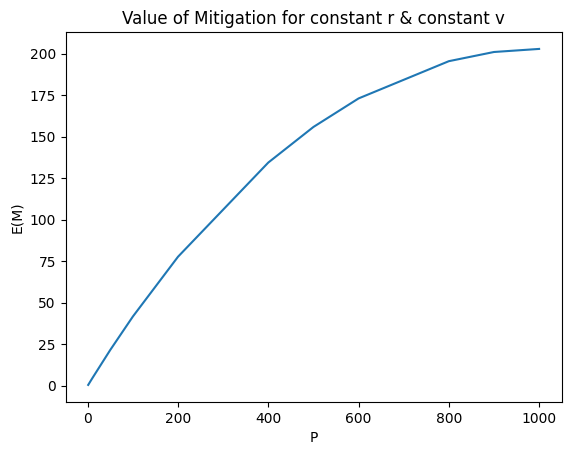

In [67]:
# Example usage
T=1000
plot_value_of_mitigation_different_Ps(T, f=0.5, Ps=[1, 5, 10, 50, 100, 200, 400, 500, 600, 800, 900, T], r_type="constant", v_type="constant")

Increasing persistence is important but it exhibits decreasing marginal returns in the concave fashion illustrated above.

This result matches our intuitions. Because of its cumulative nature, the probability of avoiding extinction in the near-term is much higher than avoiding it long-term. That means that the contributions of $E(w)$, and thus of $E(M)$, are much higher in the short term than in the long term. So the marginal gains from increasing persistence are much higher in the short term than in the long term. In other words, for example, adding 1 year of persistence to a mitigation action that lasts 1 year is much more valuable than adding 1 year of persistence to a mitigation action that lasts 100 years.

A general lesson follows: performing actions that have larger persistence is key, but increasing persistence is particularly valuable for low persistence values. 

## The value of existential risk mitigations under GFH [original]

In [1]:
import numpy as np

# Parameters
r_1 = 0.2
f = 1/2
r_M = (1-f)*r_1 # M is prime in the LaTeX
r_l = 0.001
r_2 = 0.2
F = 2
P = 20
T = 10000

# Calculate the sums for E[w_X]
sum_V_X = sum((1 - r_M)**t for t in range(1, F+1))  #+1s needed given Python syntax because range() is exclusive
sum_low_risk_X = sum((1 - r_l)**t for t in range(1, P+1))
sum_second_filter_M = sum((1 - r_2)**t for t in range(1, F+1))
sum_low_risk_infinite_X = sum((1 - r_l)**t for t in range(1, T+1))

# Calculate the sums for E[w]
sum_V_w = sum((1 - r_1)**t for t in range(1, F+1))
sum_low_risk_w = sum((1 - r_l)**t for t in range(1, P+1))
sum_second_filter_w = sum((1 - r_2)**t for t in range(1, F+1))
sum_low_risk_infinite_w = sum((1 - r_l)**t for t in range(1, T+1))

# Calculate the difference E[M] = E[w_M] - E[w]
difference = (sum_V_X - sum_V_w) + ((1 - r_M)**F - (1 - r_1)**F) * sum_low_risk_X + ((1 - r_M)**F - (1 - r_1)**F) * (1 - r_l)**P * (sum_second_filter_M - sum_second_filter_w) + ((1 - r_M)**F - (1 - r_1)**F) * (1 - r_l)**P * (1 - r_2)**F * (sum_low_risk_infinite_X - sum_low_risk_infinite_w)

print(f"Parameters:\nr_1 = {r_1}, r_M = {r_M}, r_l = {r_l}, r_2 = {r_2}, F = {F}, P = {P}, T = {T}\n")
print("The difference V[X] - V[w] is:", difference)

Parameters:
r_1 = 0.2, r_X = 0.1, r_l = 0.001, r_2 = 0.2, F = 2, P = 20, T = 10000

The difference V[X] - V[W] is: 3.6345250860001235


## Other

could be useful:

In Jupyter Notebook, you can store a plot and display it without re-running the calculations and plotting code by saving the plot as an image file and then displaying that image whenever needed. Here's a general approach:

1. Generate and plot your data as usual in a code cell.
2. Once the plot is generated, save it as an image file using a function like `savefig()` from a plotting library like Matplotlib.

```python
import matplotlib.pyplot as plt

# Generate and plot your data
# ...

# Save the plot as an image file (e.g., PNG)
plt.savefig('my_plot.png')
```

3. Later, when you want to display the plot without recalculating, you can use the `IPython.display` module to show the saved image in a Markdown cell using the `Image` class.

```python
from IPython.display import Image, display

# Display the saved plot image
display(Image(filename='my_plot.png'))
```

By following this approach, the plot will be ready for display without re-running the calculations or plotting code. Just make sure to adjust the file paths and names accordingly to match your use case.